In [15]:
from database.market import Market
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.adatabase import ADatabase
import pickle
import matplotlib.pyplot as plt

In [2]:
strat = ADatabase("cfa")

In [3]:
market = Market()
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()

In [4]:
factors=['assets', 'liabilitiesandstockholdersequity',
       'earningspersharebasic', 'earningspersharediluted',
       'stockholdersequity', 'netincomeloss', 'assetscurrent',
       'liabilitiescurrent','adjclose']

In [23]:
year = 2021
quarter = 2
projection_value = 4
training_year = 1

In [6]:
strat.connect()
models = strat.retrieve("models")
strat.disconnect()

In [7]:
models

api                                              model     score  \
0  skl  b'\x80\x04\x95Z\x03\x00\x00\x00\x00\x00\x00\x8...  0.956627   
1  xgb  b'\x80\x04\x95u\x02\x00\x00\x00\x00\x00\x00\x8...  0.971518   
2  cat  b'\x80\x04\x95\x9b\x00\x00\x00\x00\x00\x00\x00...  0.965736   

   model_type  year  quarter  projection_Value  training_year  
0  regression  2021        2                 4              1  
1  regression  2021        2                 4              1  
2  regression  2021        2                 4              1

In [9]:
models["model"] = [pickle.loads(x) for x in models["model"]]

In [10]:
ds = []
market.connect()
for ticker in sp500["Symbol"]:
    try:
        filing = market.retrieve_high_level_filings(ticker)
        filing = p.column_date_processing(filing)
        filing.sort_values("date",inplace=True)
        filing["y"] = filing['adjclose'].shift(-projection_value)
        ds.append(filing)
    except Exception as e:
        continue
market.disconnect()
rekt = pd.concat(ds)
rekt.dropna(inplace=True)

In [25]:
strat.connect()
start_year = int(year - projection_value/4)
end_year = start_year + 2
for year in tqdm(range(start_year,int(end_year))):
    try:
        prediction_set = rekt[(rekt["year"]==year)]
        for row in models.iterrows():
            try:
                model = row[1]["model"]
                api = row[1]["api"]
                prediction_set[f"{api}_prediction"] = model.predict(prediction_set[factors])
            except Exception as e:
                print(str(e))
        prediction_set["prediction"] = (prediction_set["skl_prediction"] + prediction_set["xgb_prediction"] + prediction_set["cat_prediction"]) / 3
        prediction_set["new_quarter"] = [(row[1]["quarter"] + projection_value) % 4 for row in prediction_set.iterrows()]
        prediction_set["new_quarter"] = prediction_set["new_quarter"].replace(0,4)
        prediction_set["new_year"] = [row[1]["year"] if row[1]["quarter"] + projection_value <=4 \
                                      else row[1]["year"]+ projection_value/4 for row in prediction_set.iterrows()]
        prediction_set = prediction_set[["new_year","new_quarter","ticker","prediction","adjclose"]].rename(columns={"new_year":"year","new_quarter":"quarter"})
        prediction_set["training_year"] = training_year
        prediction_set["projection_value"] = projection_value
    except:
        continue
    strat.disconnect()

100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]


MMM


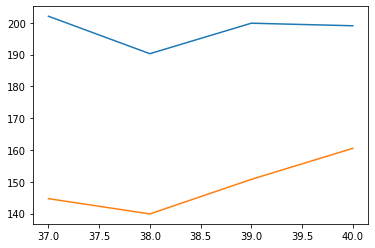

AOS


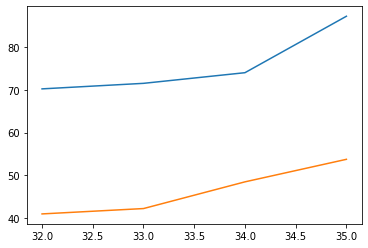

ABT


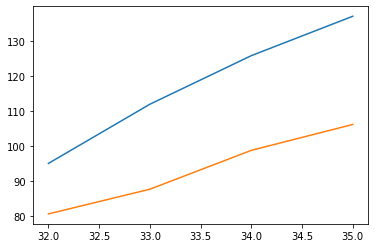

ABBV


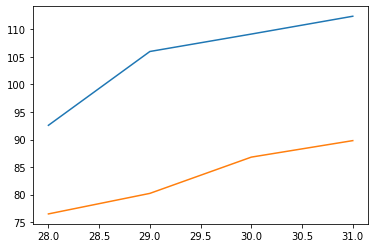

ABMD


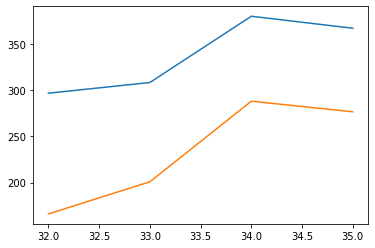

ACN


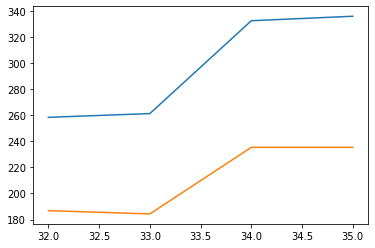

ATVI


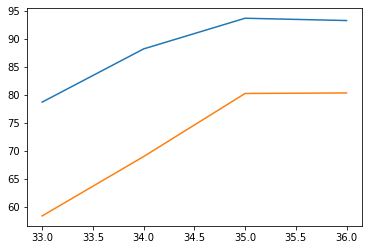

ADM


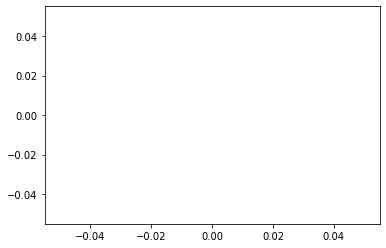

ADBE


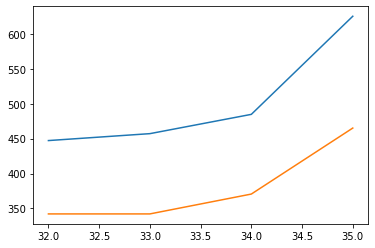

ADP


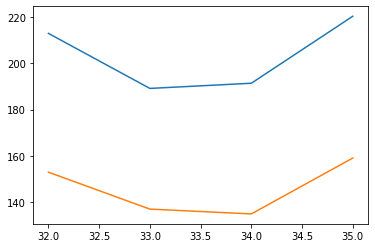

AAP


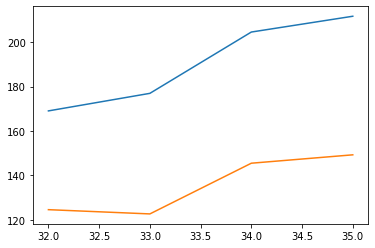

AES


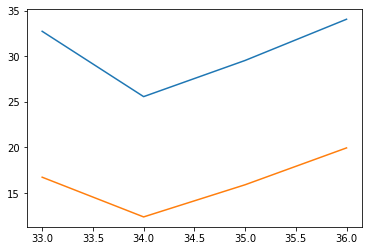

AFL


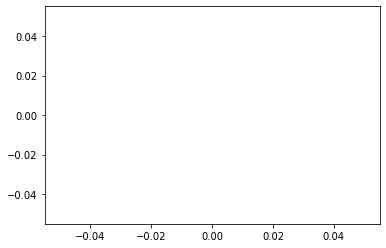

A


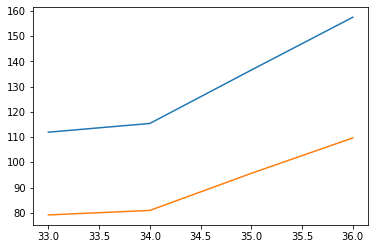

APD


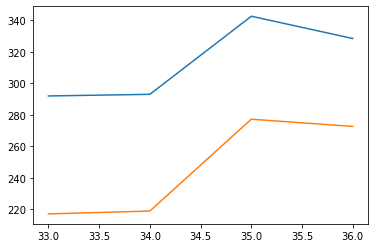

AKAM


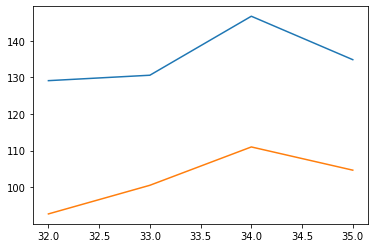

ALK


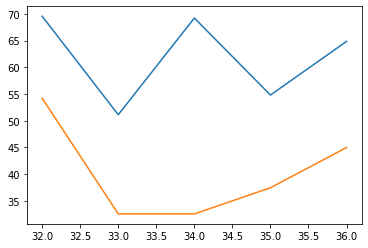

ALB


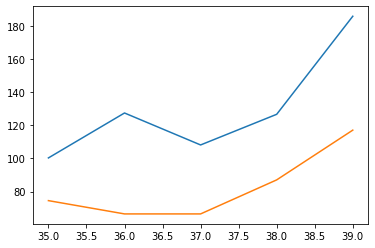

ARE


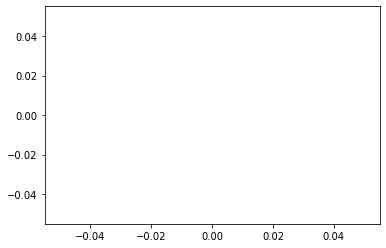

ALGN


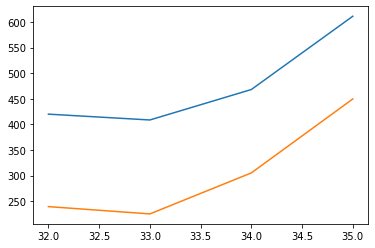

ALLE


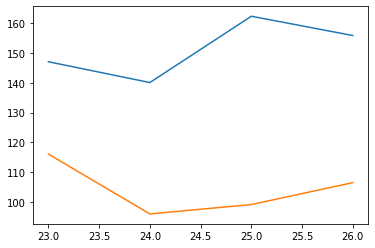

LNT


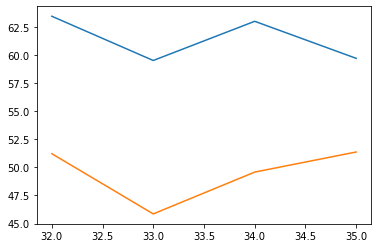

ALL


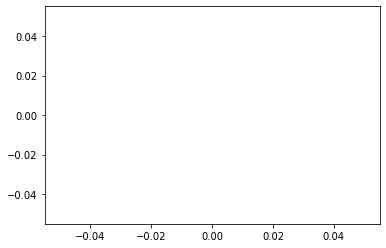

GOOGL


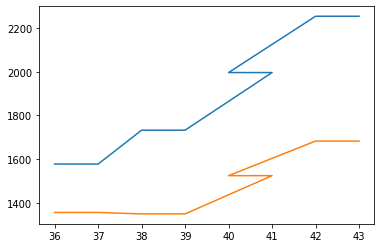

GOOG


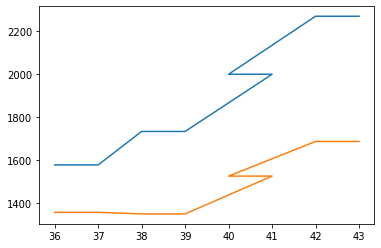

MO


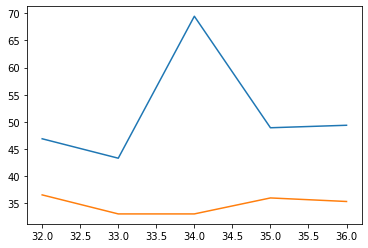

AMZN


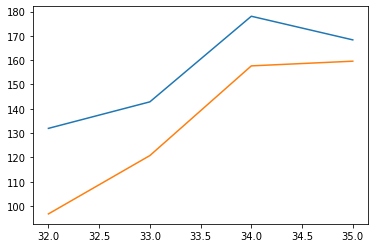

AMCR


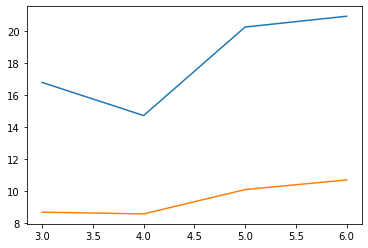

AMD


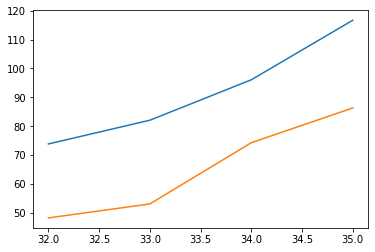

AEE


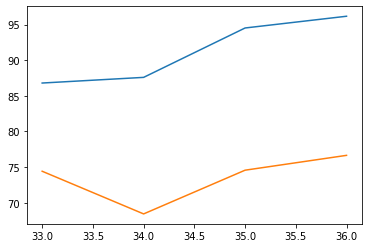

AAL


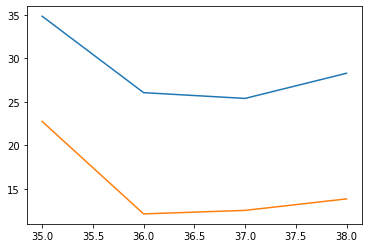

AEP


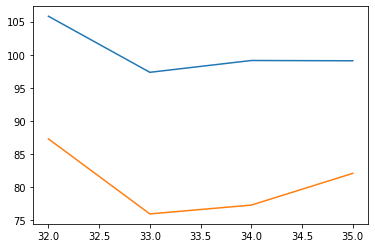

AXP


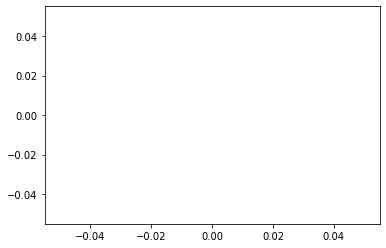

AIG


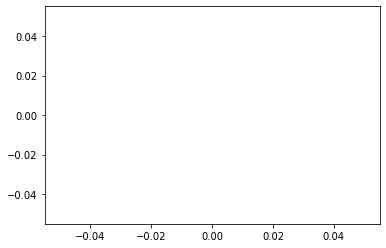

AMT


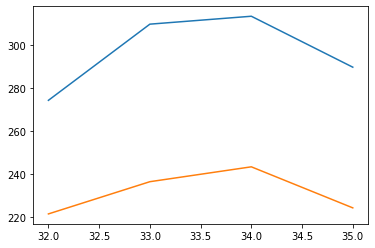

AWK


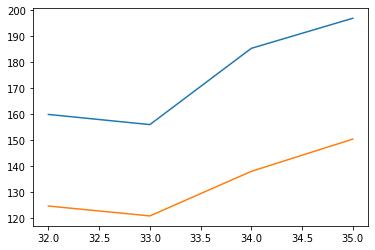

AMP


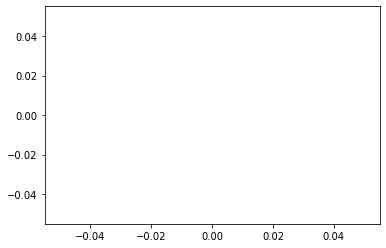

ABC


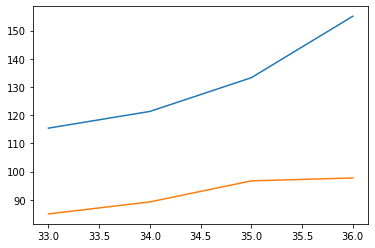

AME


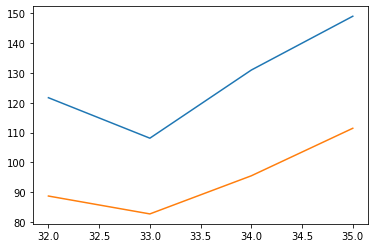

AMGN


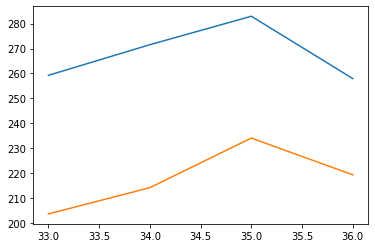

APH


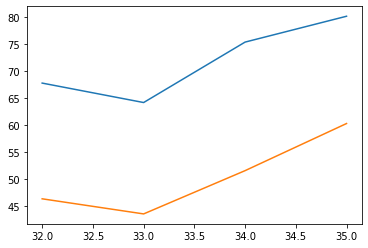

ADI


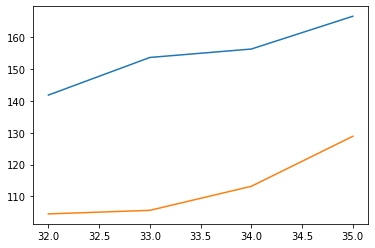

ANSS


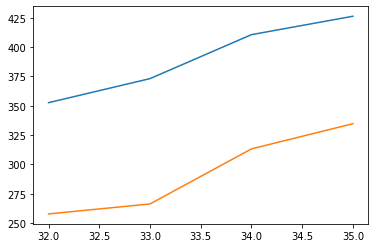

ANTM


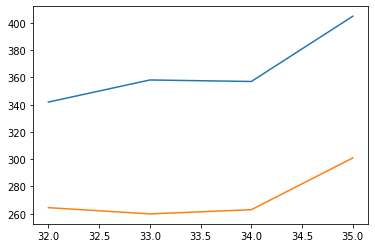

AON


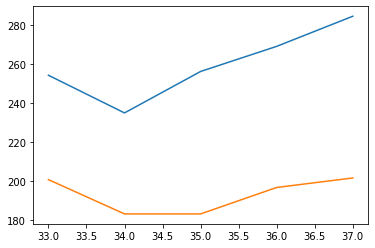

APA


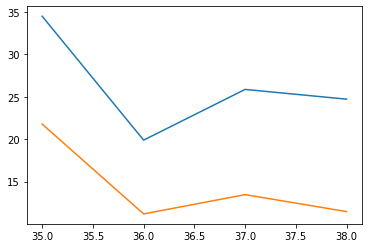

AAPL


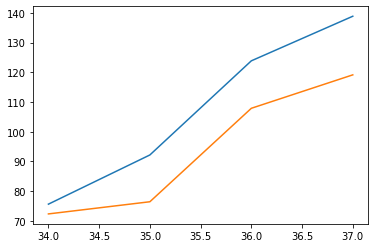

AMAT


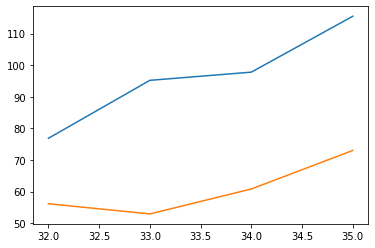

APTV


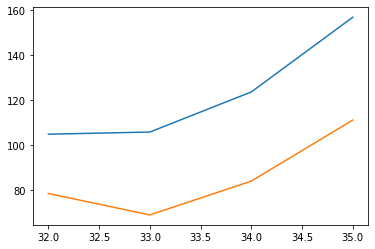

ANET


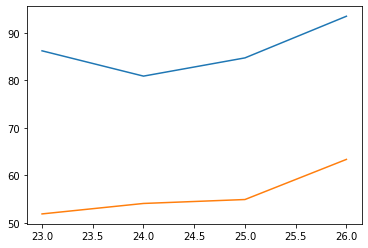

AJG


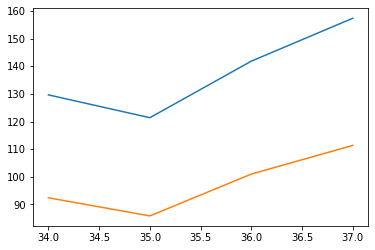

AIZ


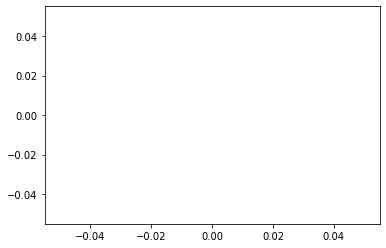

T


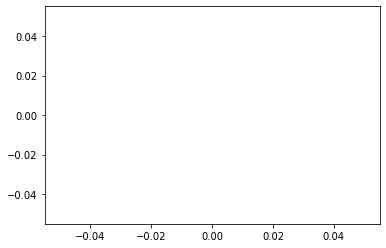

ATO


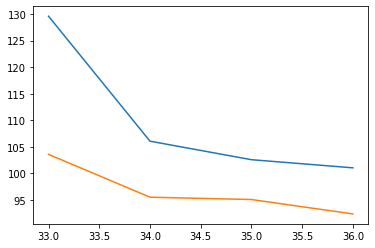

ADSK


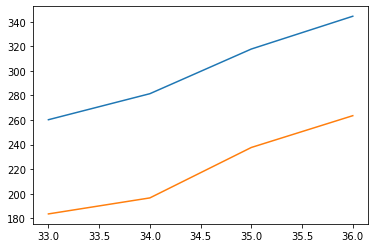

AZO


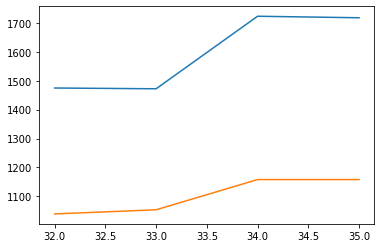

AVB


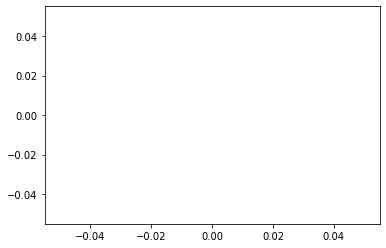

AVY


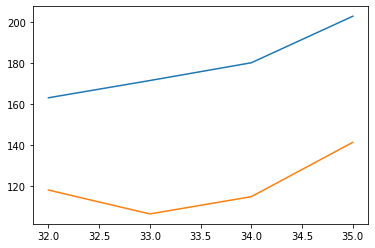

BKR


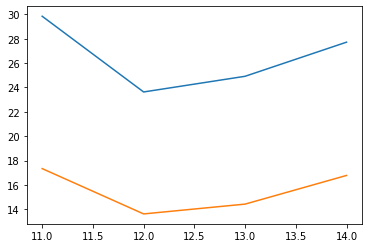

BALL


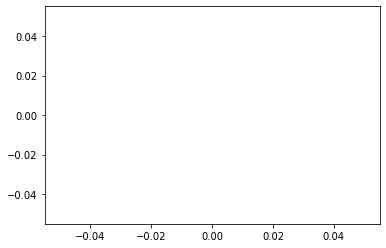

BAC


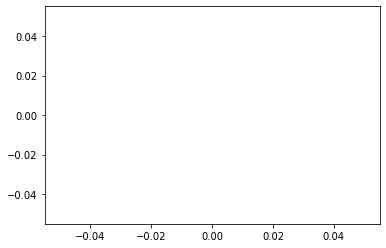

BBWI


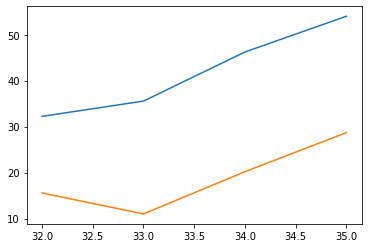

BAX


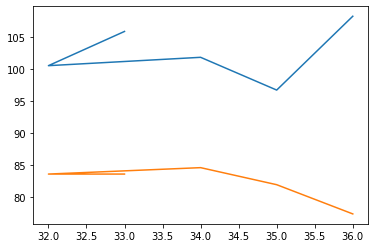

BDX


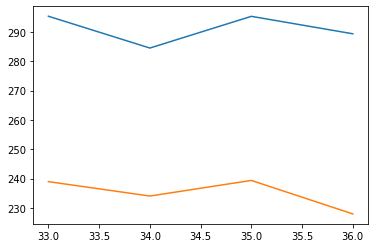

WRB


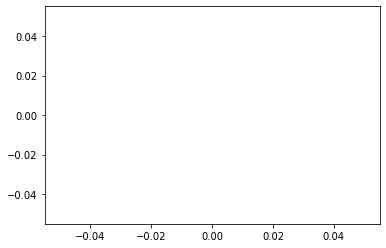

BRK.B


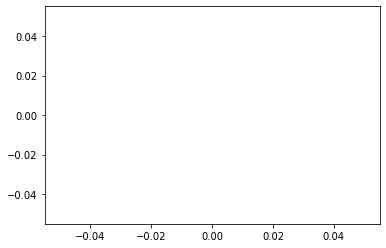

BBY


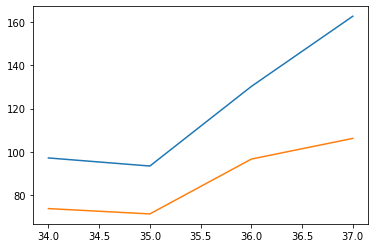

BIO


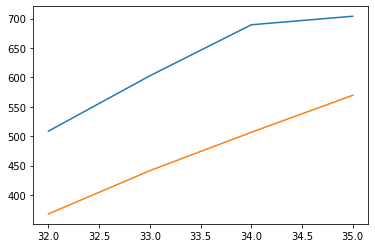

TECH


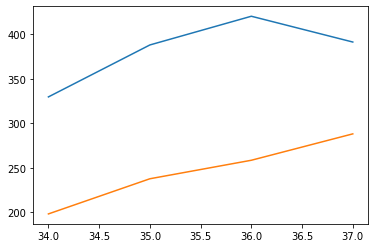

BIIB


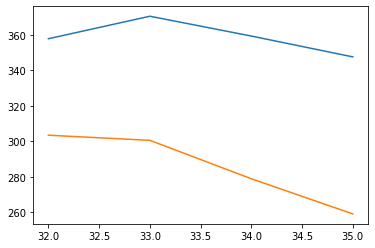

BLK


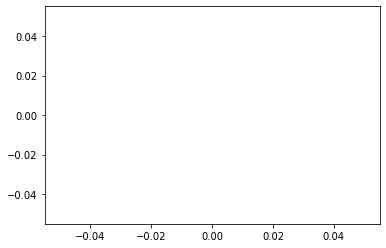

BK


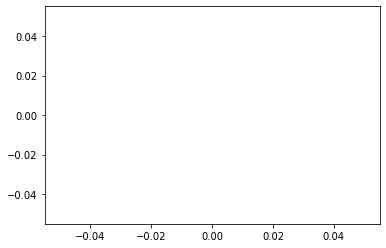

BA


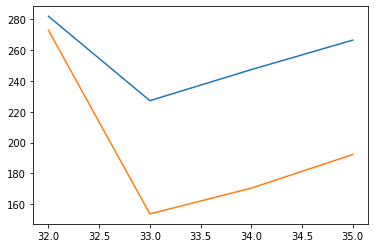

BKNG


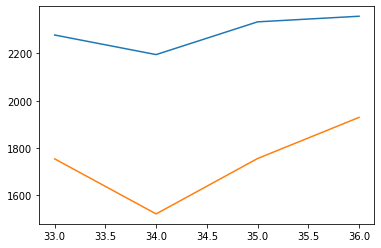

BWA


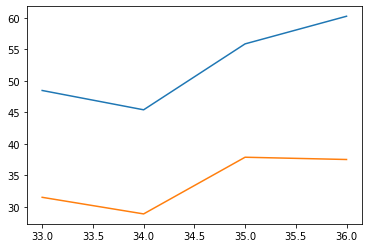

BXP


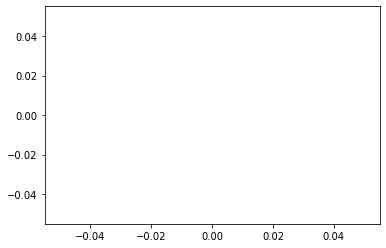

BSX


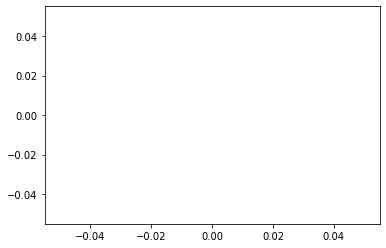

BMY


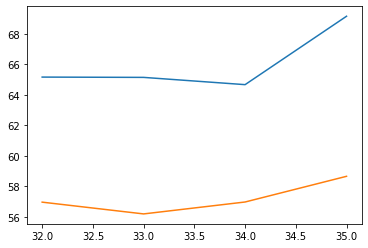

AVGO


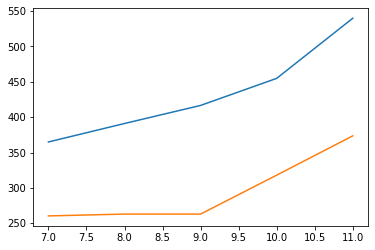

BR


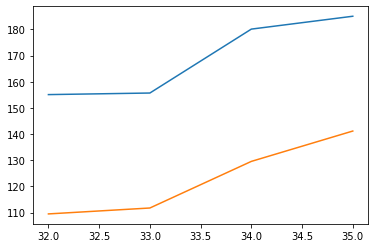

BRO


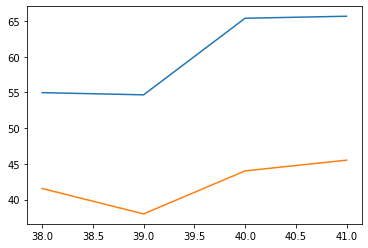

BF.B


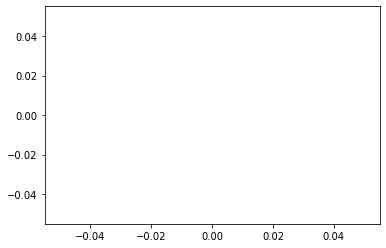

CHRW


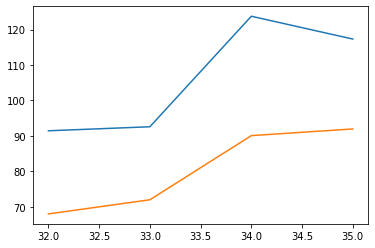

CDNS


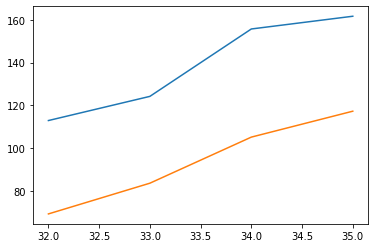

CZR


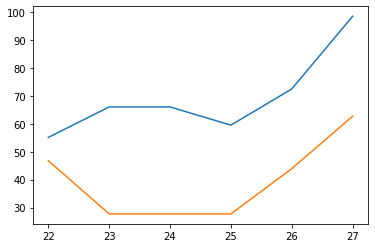

CPT


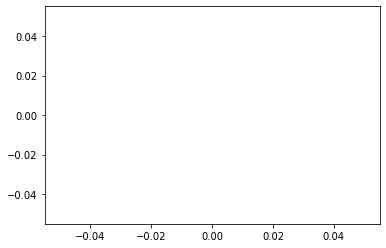

CPB


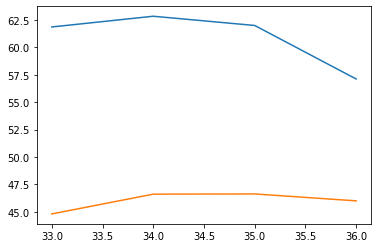

COF


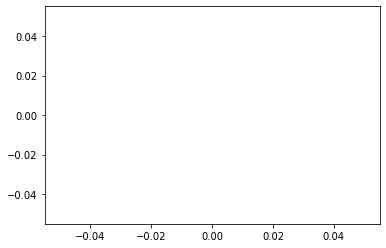

CAH


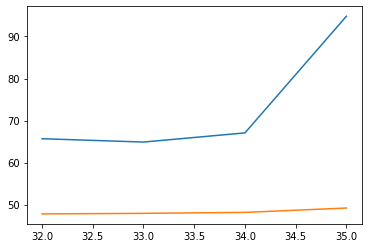

KMX


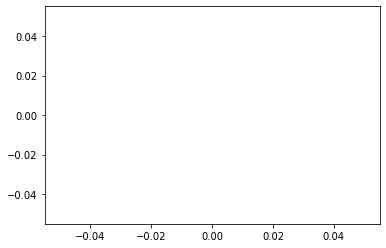

CCL


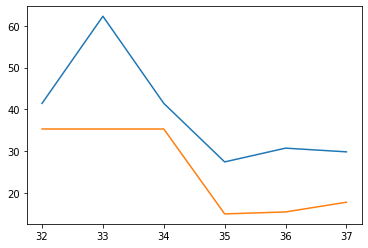

CARR


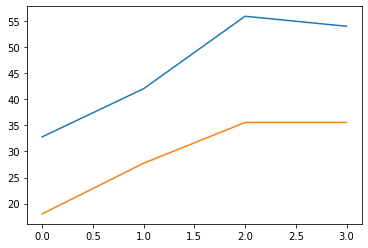

CTLT


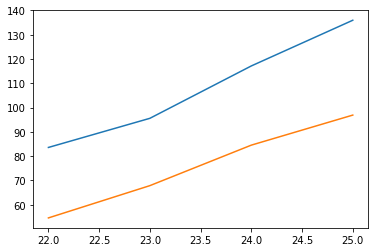

CAT


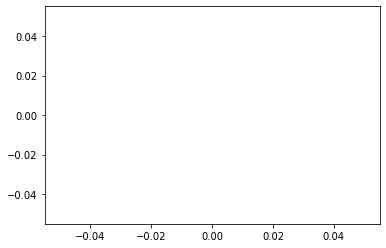

CBOE


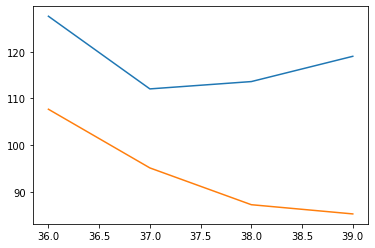

CBRE


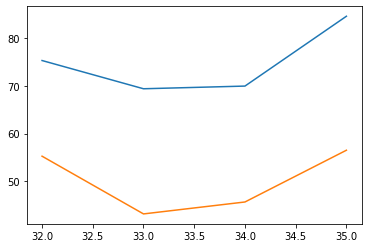

CDW


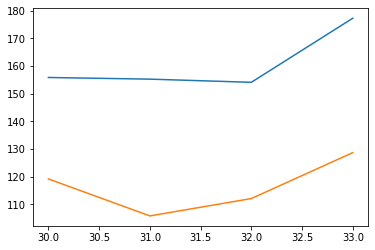

CE


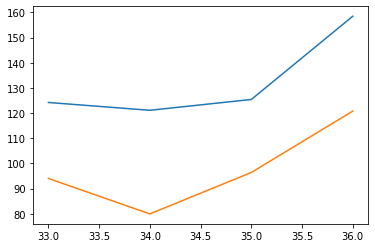

CNC


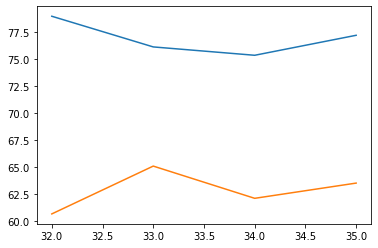

CNP


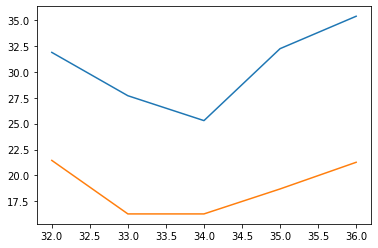

CDAY


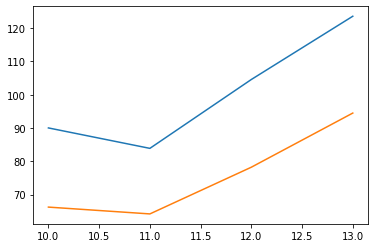

CF


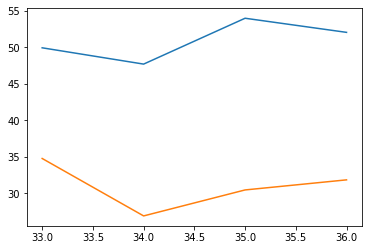

CRL


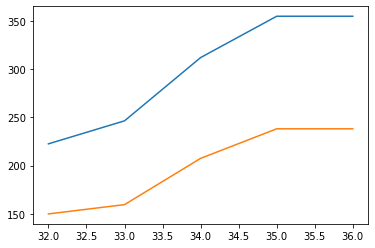

SCHW


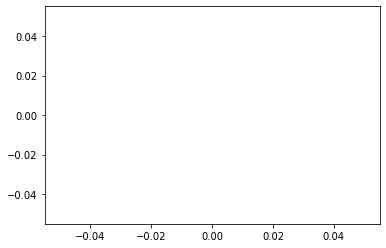

CHTR


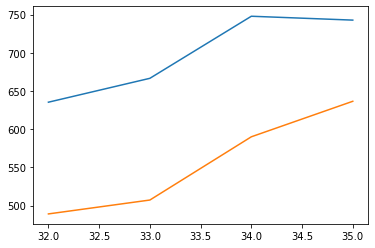

CVX


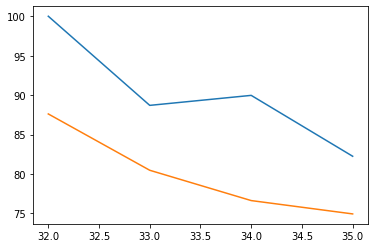

CMG


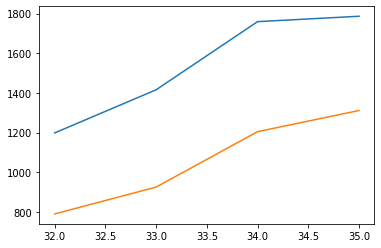

CB


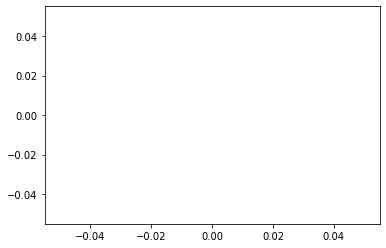

CHD


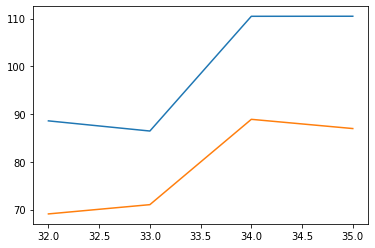

CI


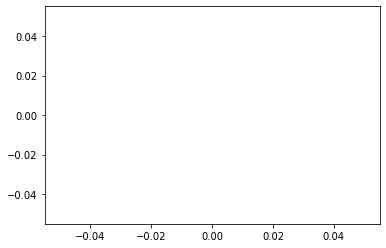

CINF


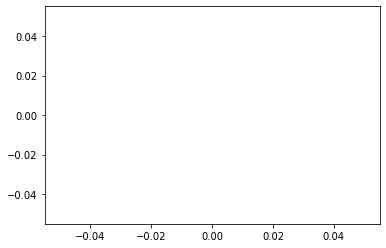

CTAS


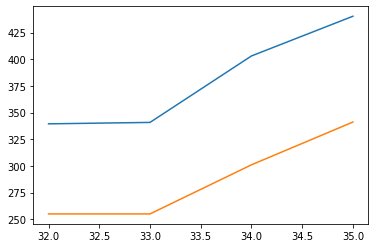

CSCO


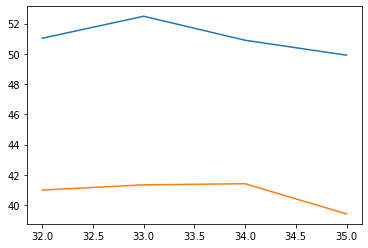

C


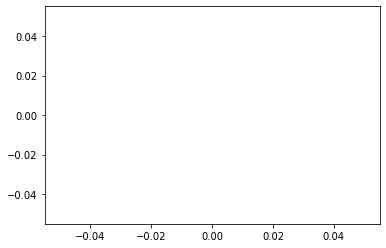

CFG


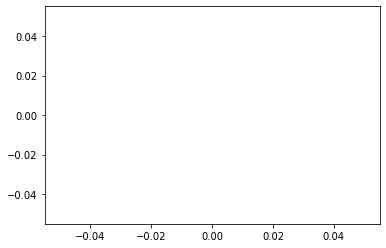

CTXS


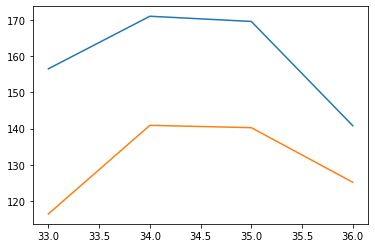

CLX


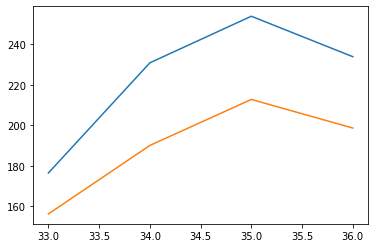

CME


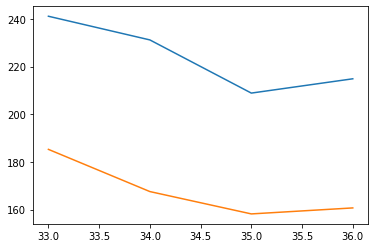

CMS


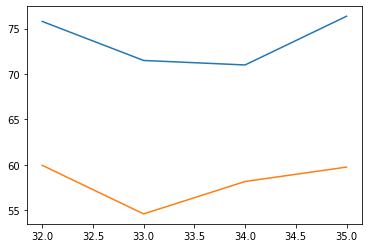

KO


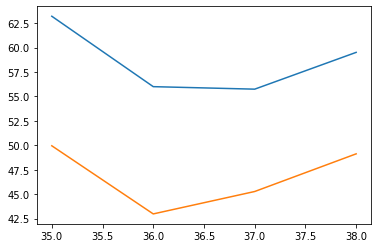

CTSH


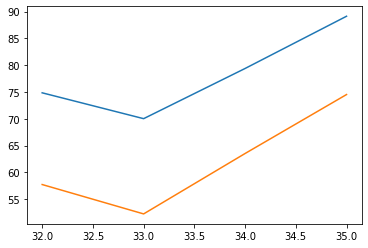

CL


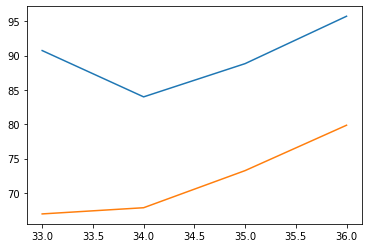

CMCSA


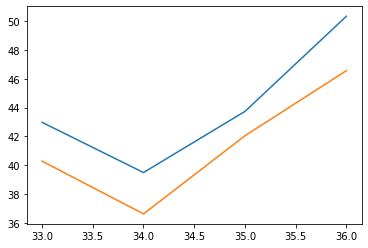

CMA


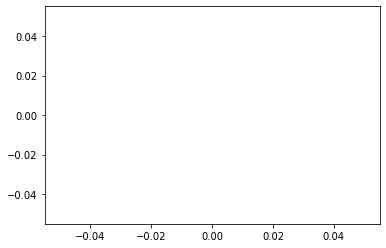

CAG


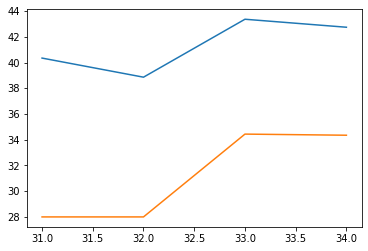

COP


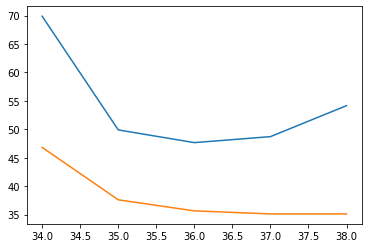

ED


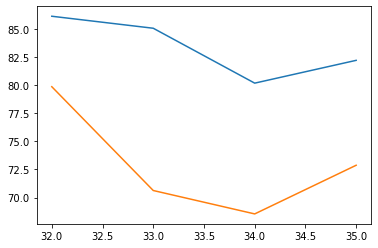

STZ


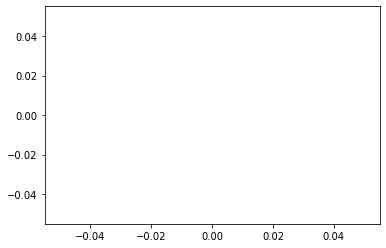

CEG


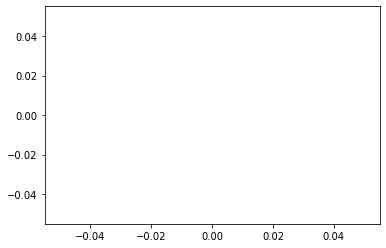

COO


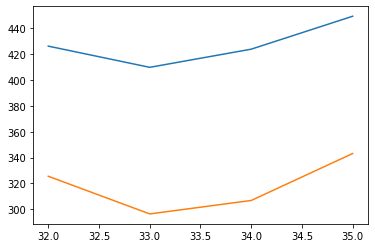

CPRT


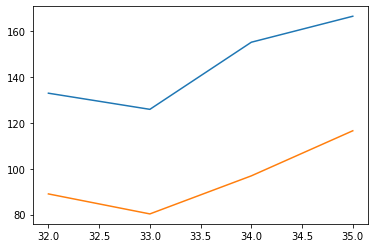

GLW


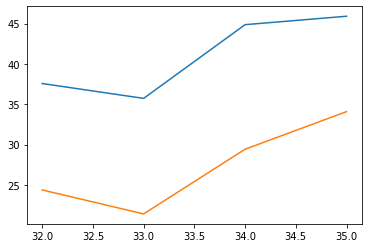

CTVA


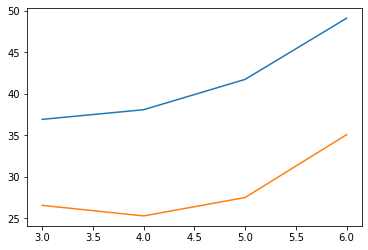

COST


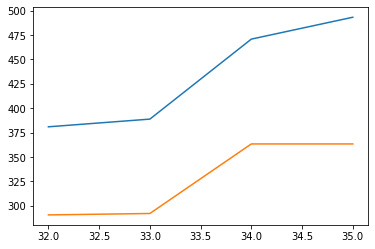

CTRA


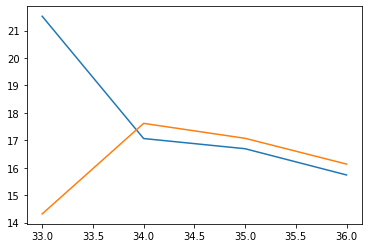

CCI


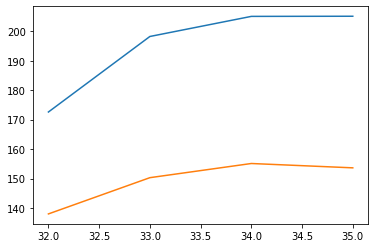

CSX


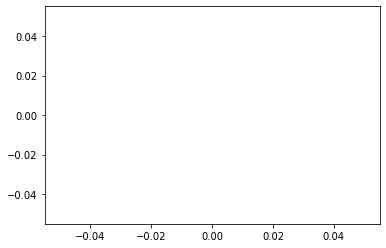

CMI


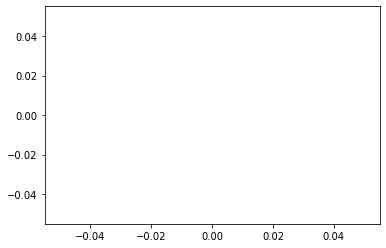

CVS


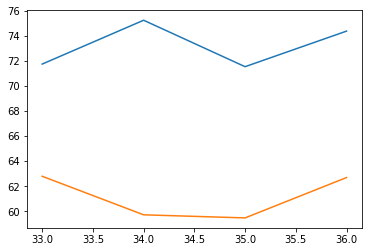

DHI


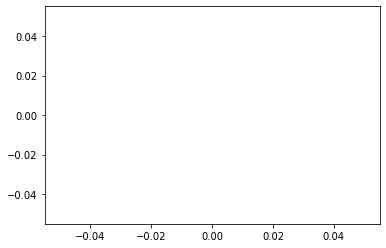

DHR


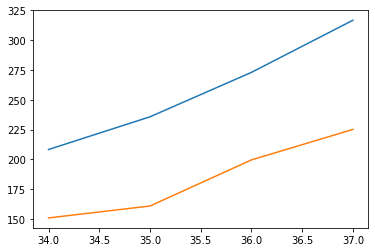

DRI


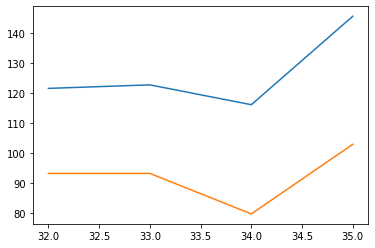

DVA


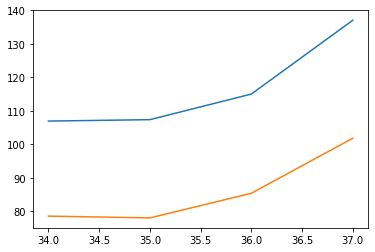

DE


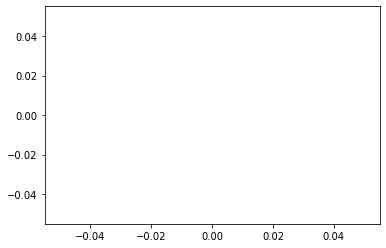

DAL


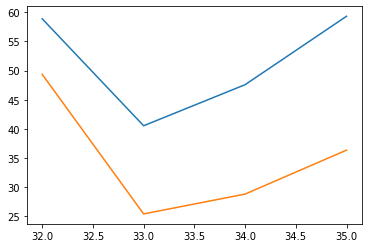

XRAY


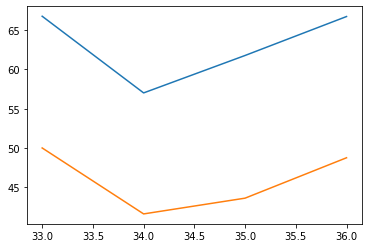

DVN


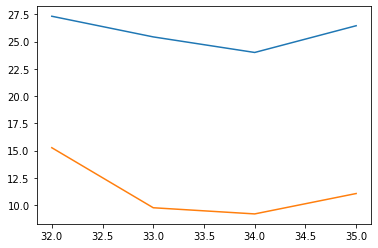

DXCM


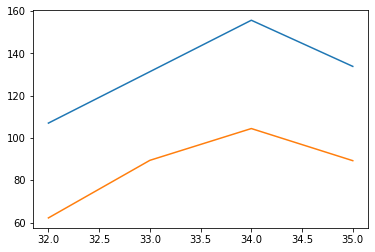

FANG


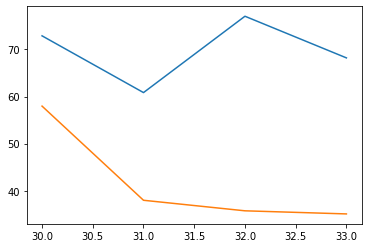

DLR


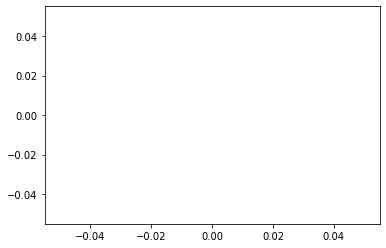

DFS


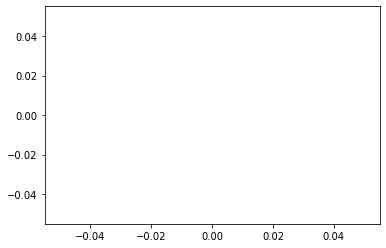

DISH


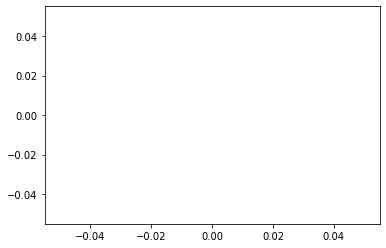

DIS


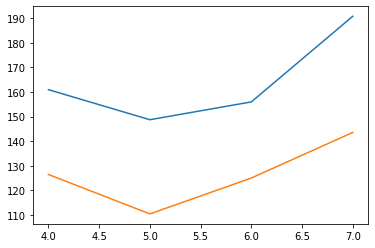

DG


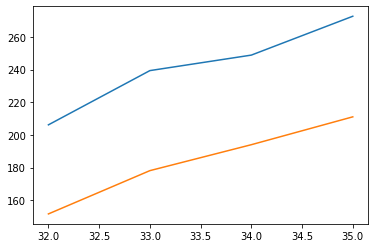

DLTR


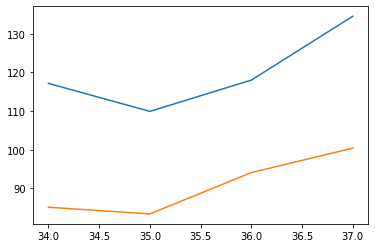

D


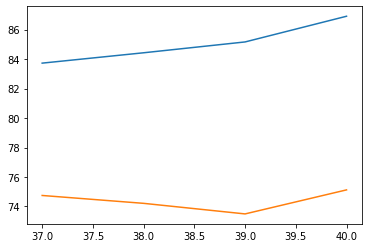

DPZ


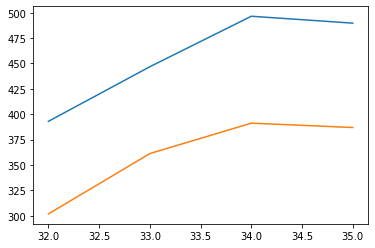

DOV


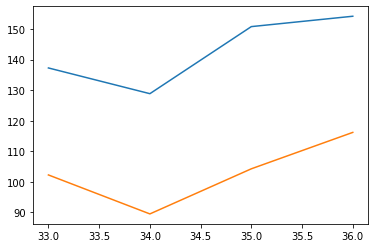

DOW


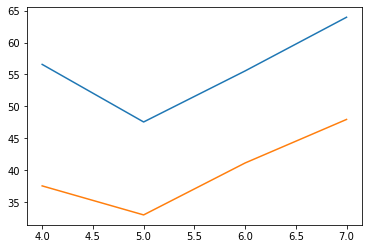

DTE


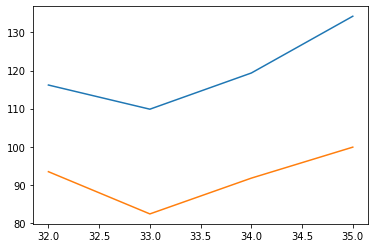

DUK


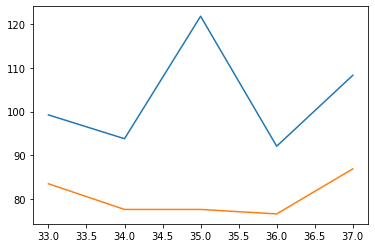

DRE


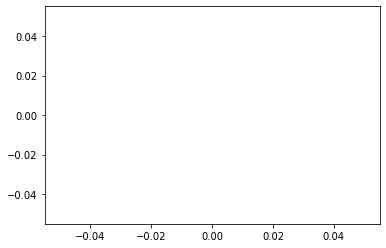

DD


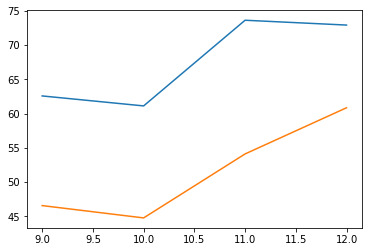

DXC


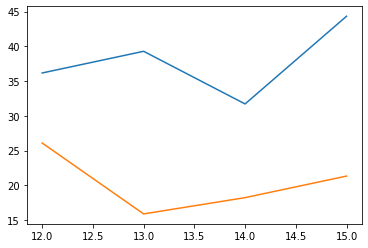

EMN


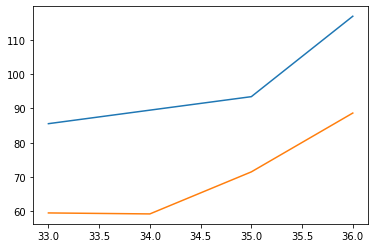

ETN


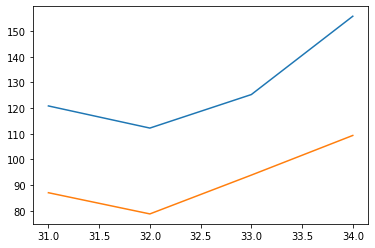

EBAY


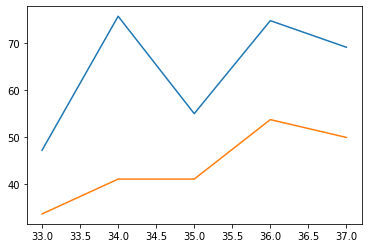

ECL


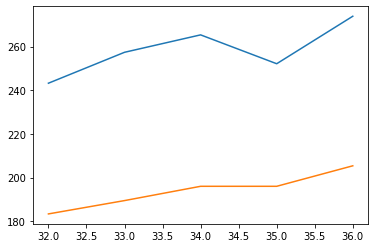

EIX


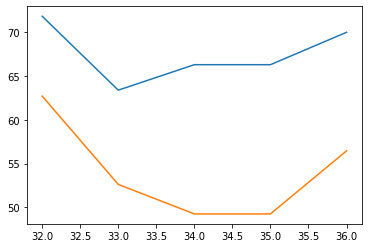

EW


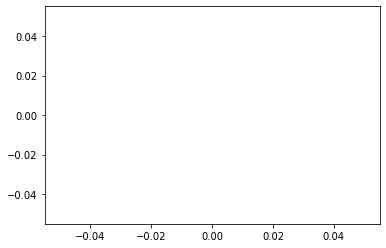

EA


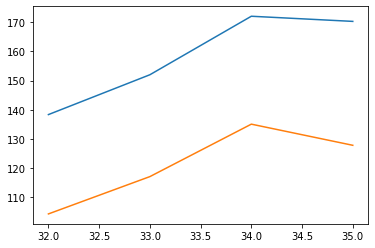

LLY


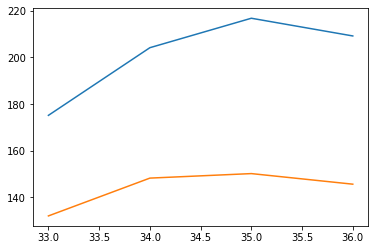

EMR


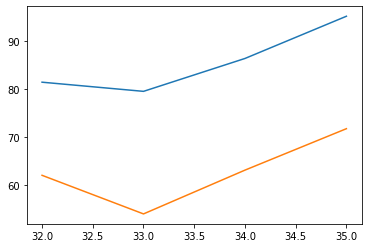

ENPH


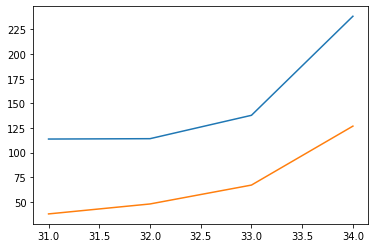

ETR


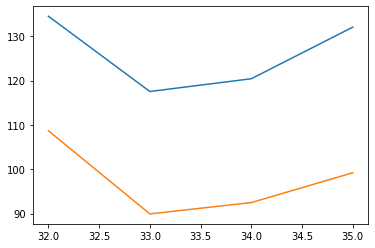

EOG


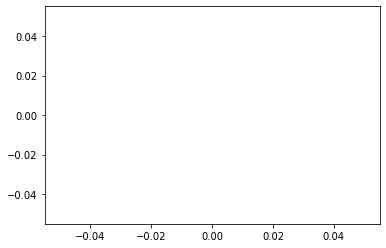

EPAM


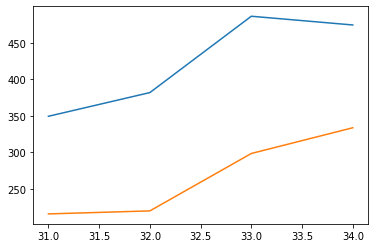

EFX


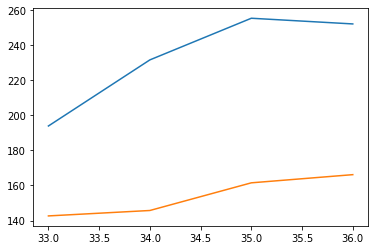

EQIX


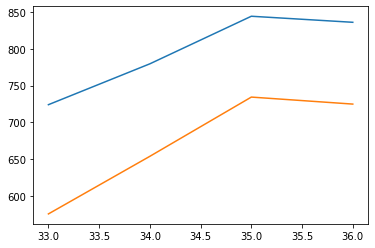

EQR


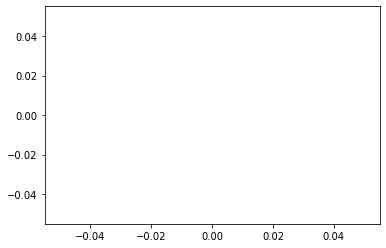

ESS


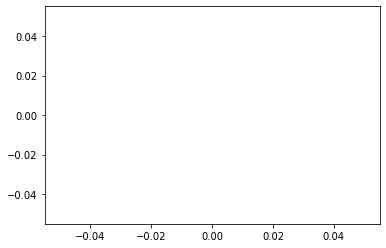

EL


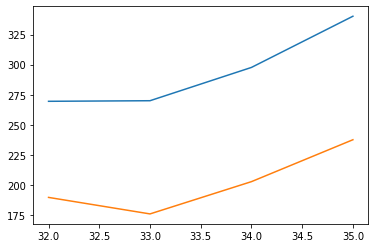

ETSY


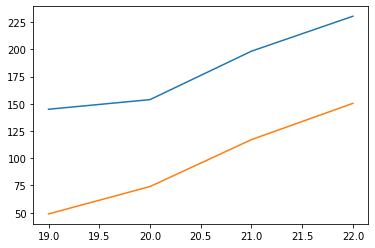

RE


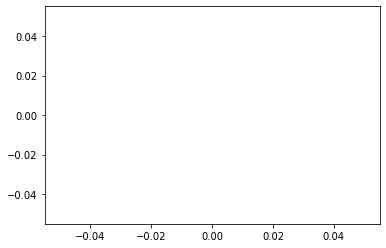

EVRG


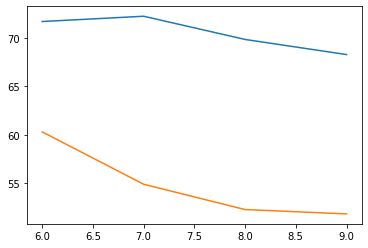

ES


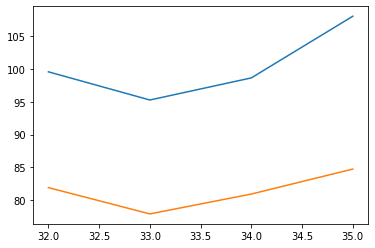

EXC


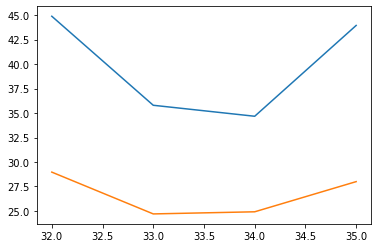

EXPE


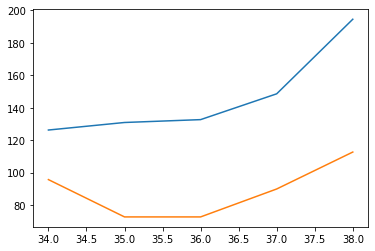

EXPD


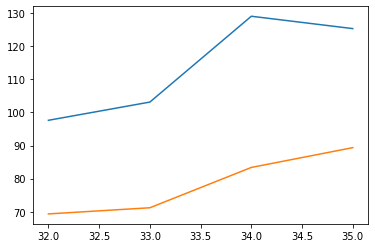

EXR


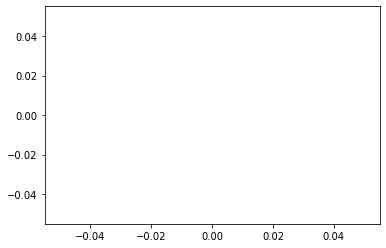

XOM


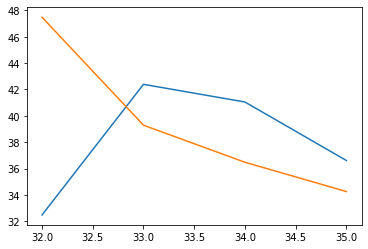

FFIV


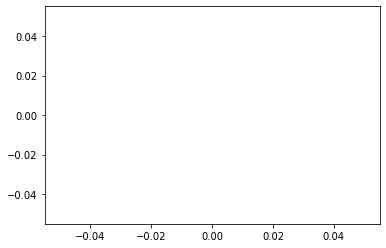

FDS


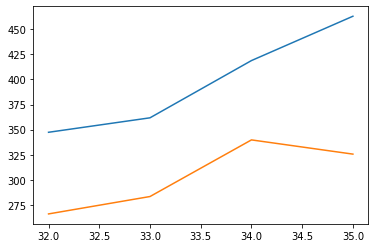

FAST


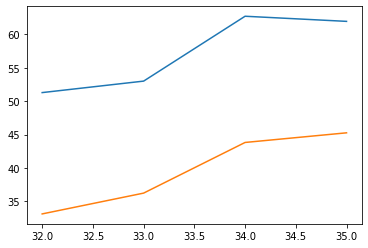

FRT


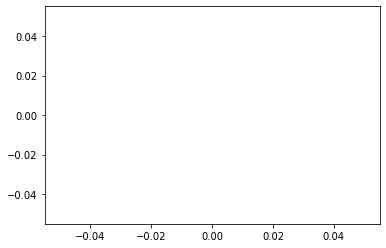

FDX


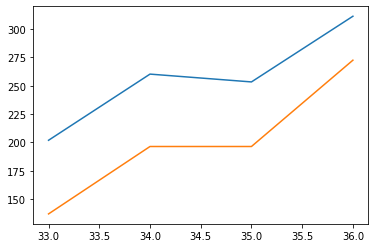

FITB


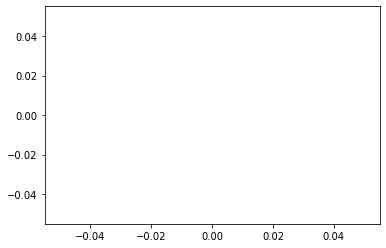

FRC


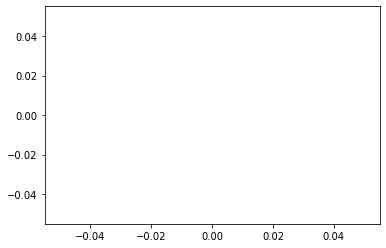

FE


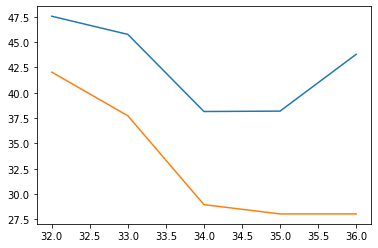

FIS


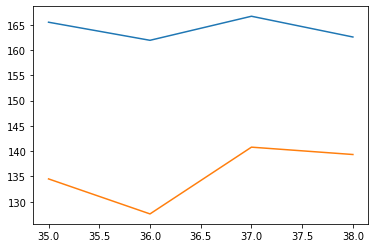

FISV


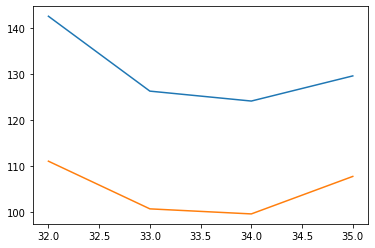

FLT


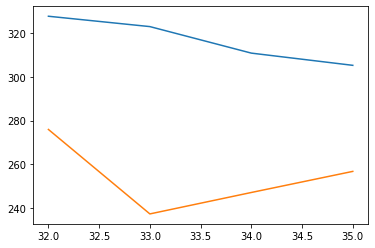

FMC


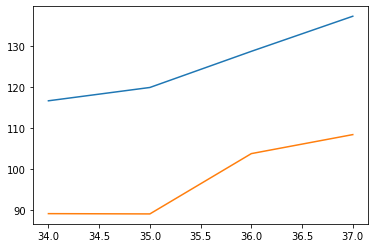

F


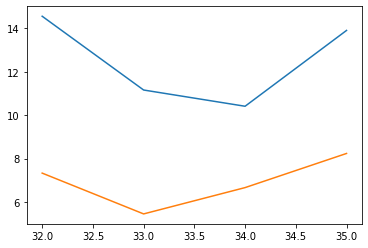

FTNT


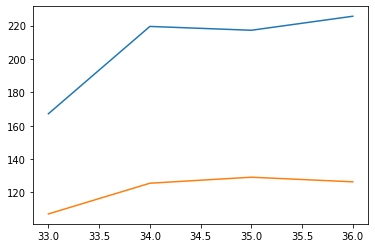

FTV


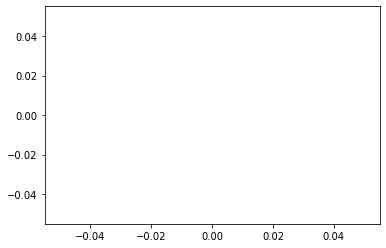

FBHS


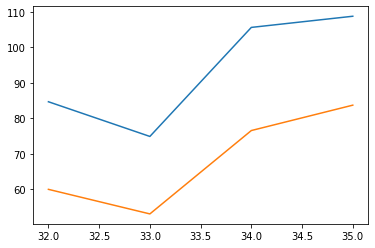

FOXA


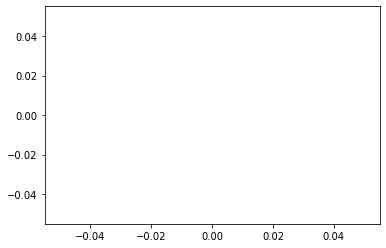

FOX


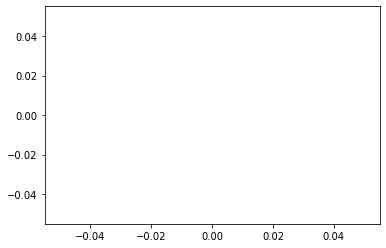

BEN


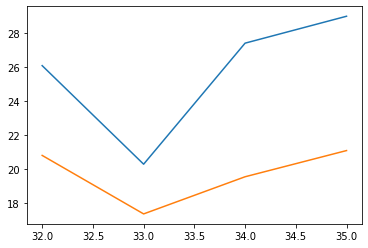

FCX


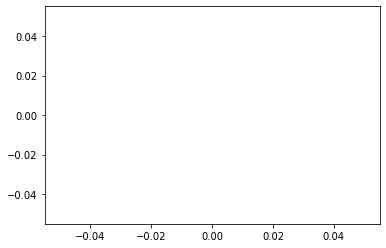

GRMN


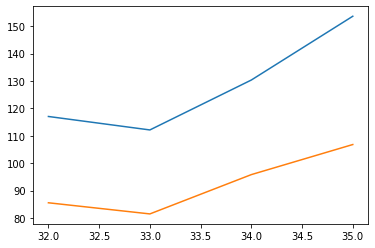

IT


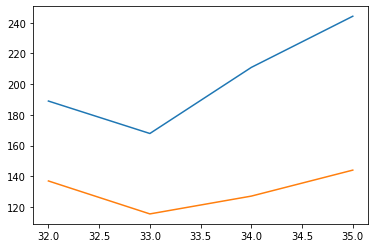

GE


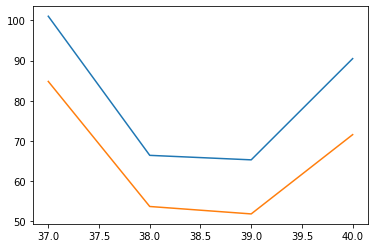

GNRC


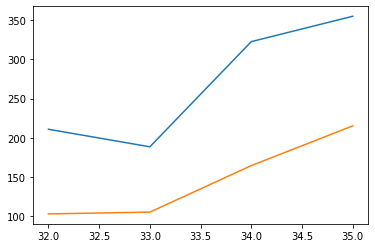

GD


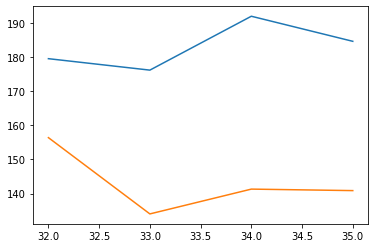

GIS


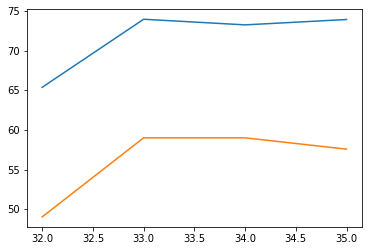

GM


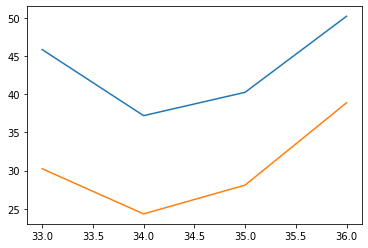

GPC


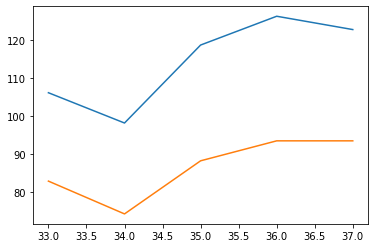

GILD


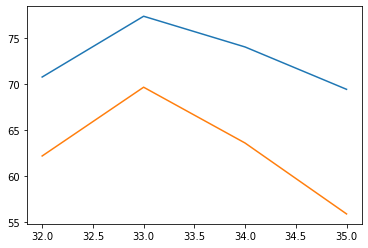

GL


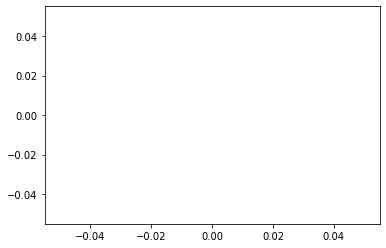

GPN


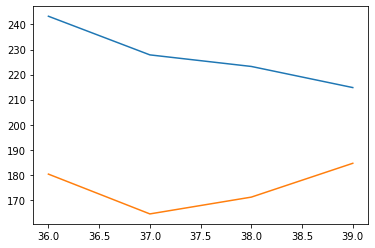

GS


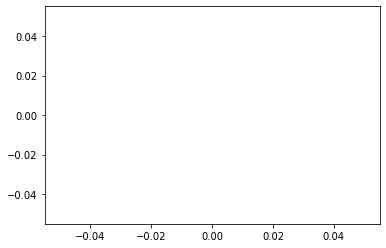

HAL


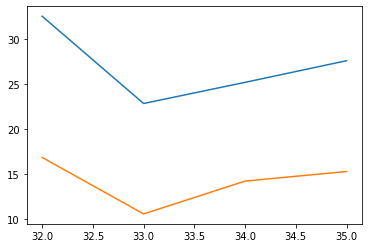

HIG


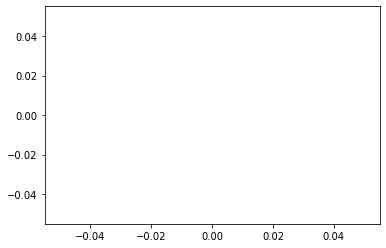

HAS


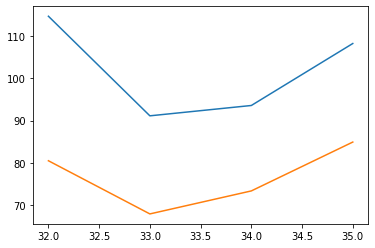

HCA


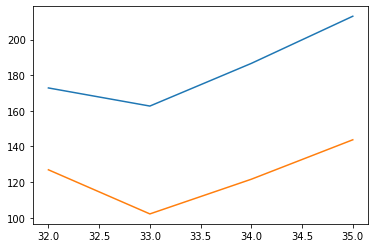

PEAK


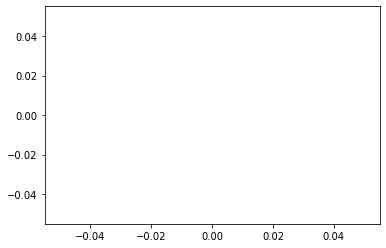

HSIC


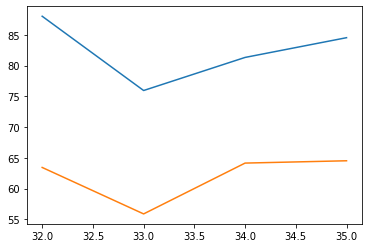

HSY


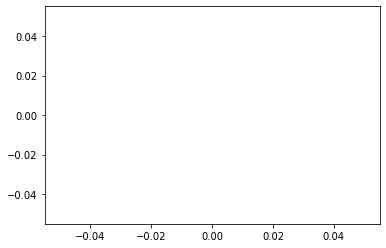

HES


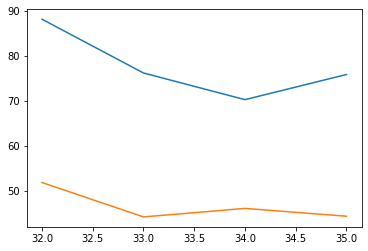

HPE


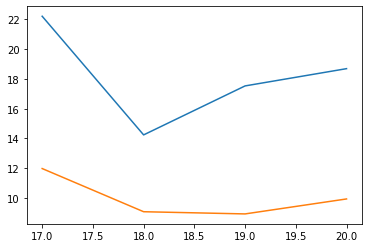

HLT


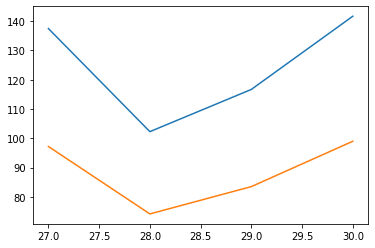

HOLX


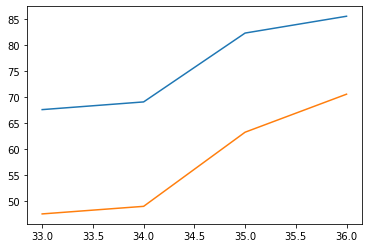

HD


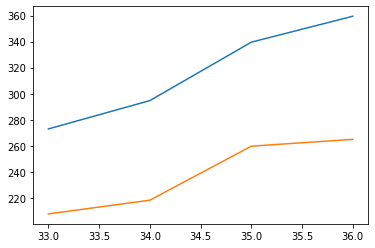

HON


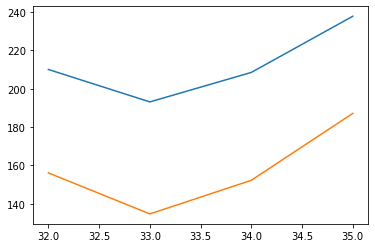

HRL


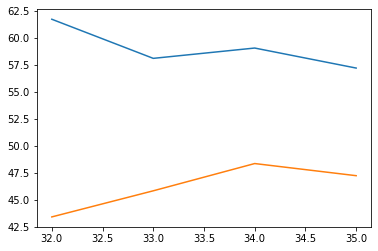

HST


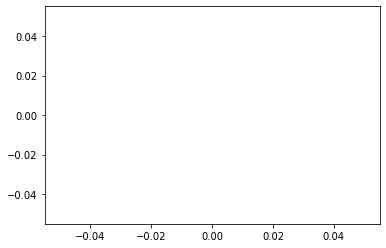

HWM


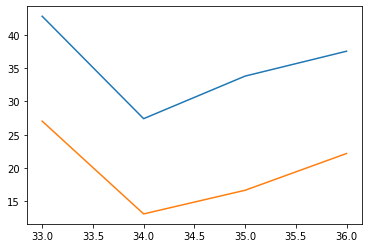

HPQ


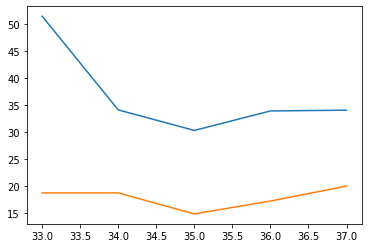

HUM


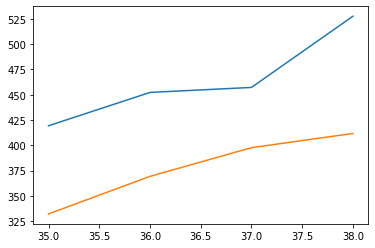

HII


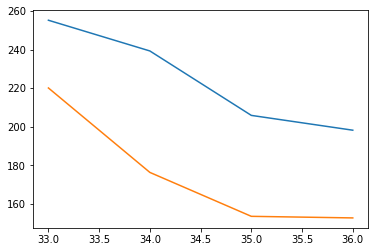

HBAN


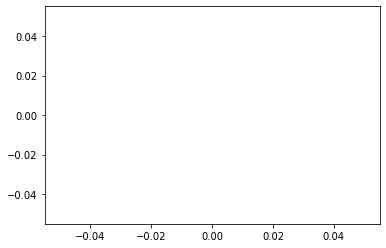

IBM


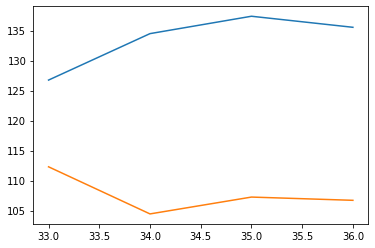

IEX


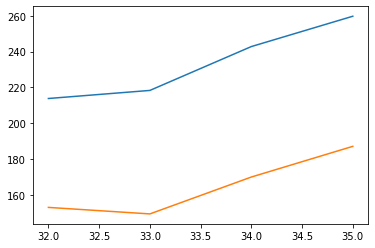

IDXX


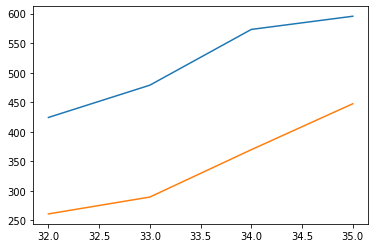

ITW


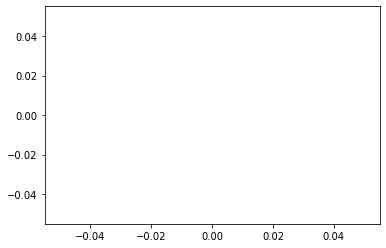

ILMN


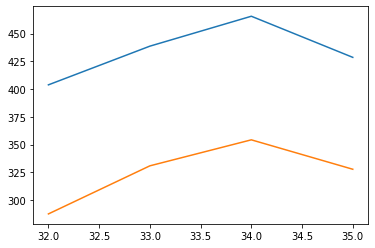

INCY


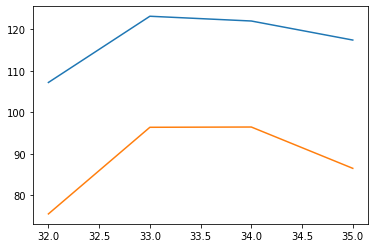

IR


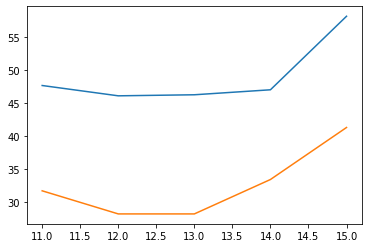

INTC


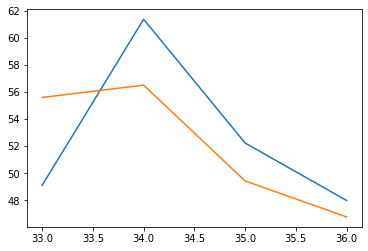

ICE


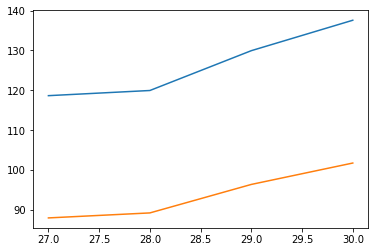

IP


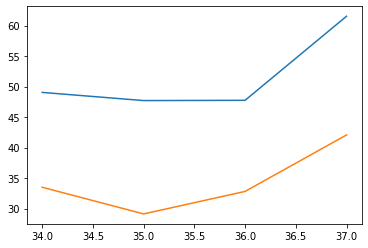

IPG


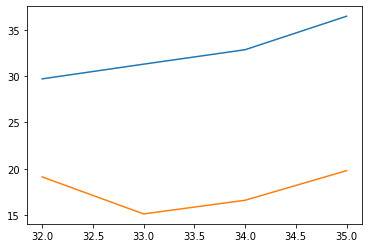

IFF


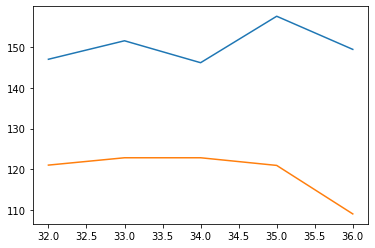

INTU


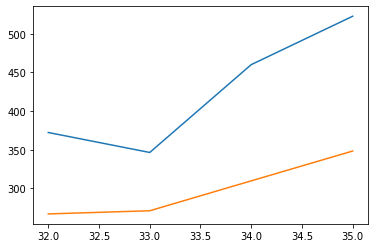

ISRG


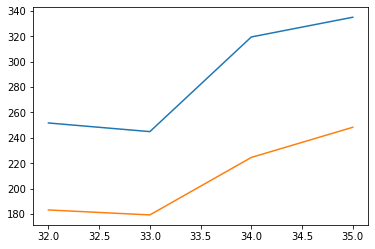

IVZ


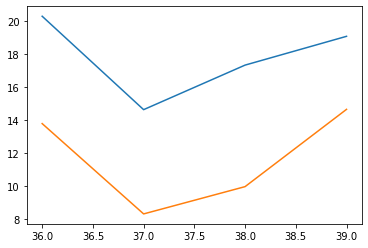

IPGP


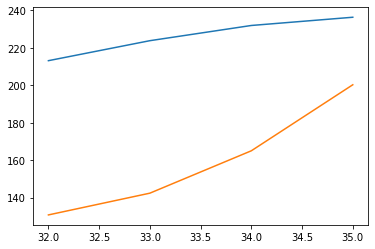

IQV


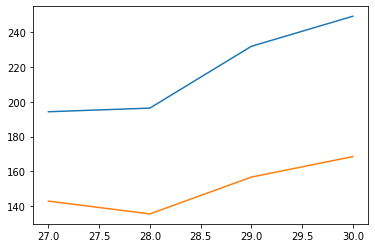

IRM


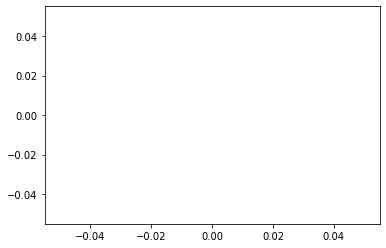

JBHT


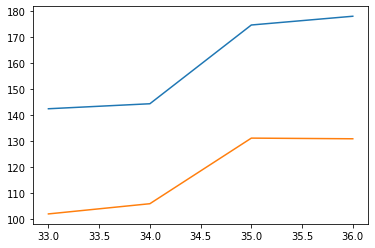

JKHY


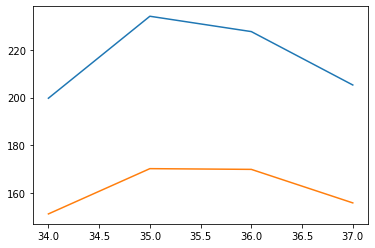

J


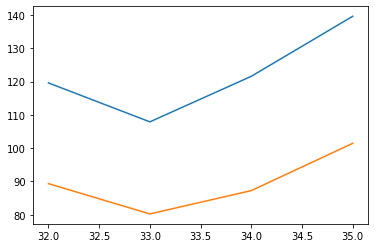

JNJ


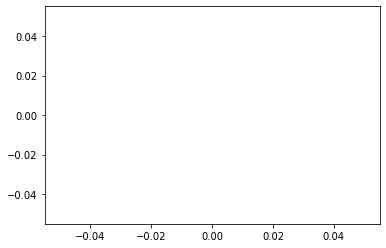

JCI


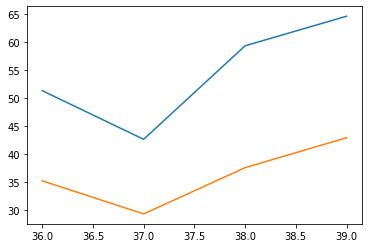

JPM


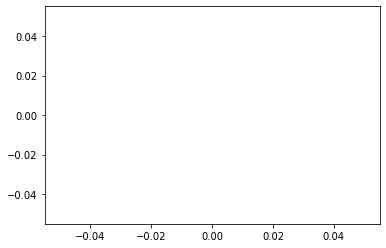

JNPR


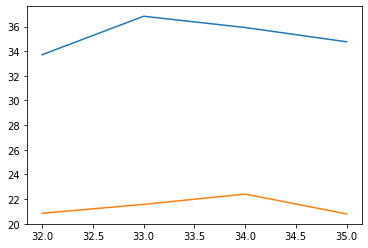

K


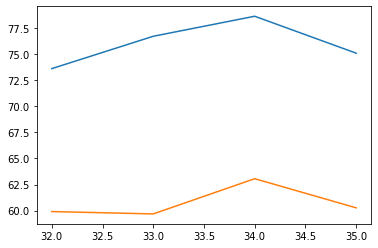

KEY


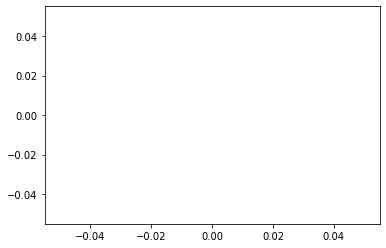

KEYS


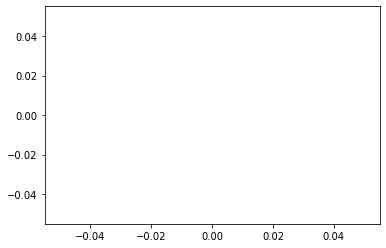

KMB


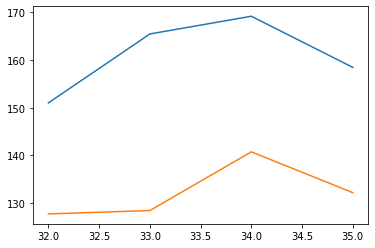

KIM


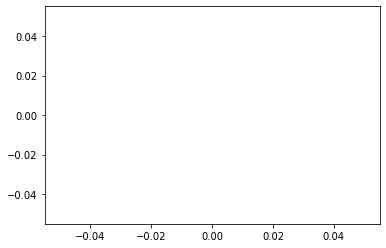

KMI


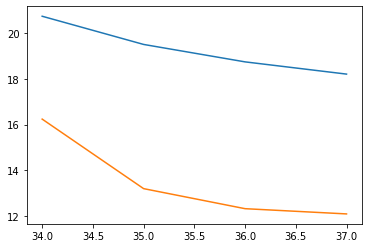

KLAC


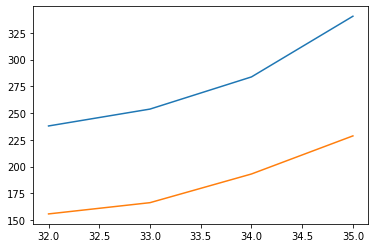

KHC


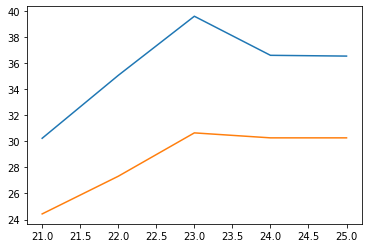

KR


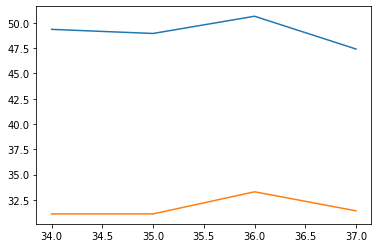

LHX


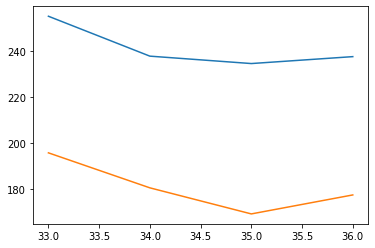

LH


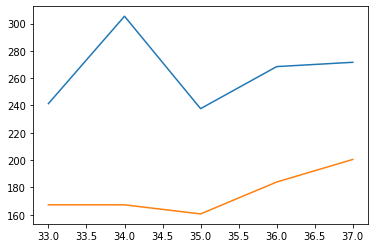

LRCX


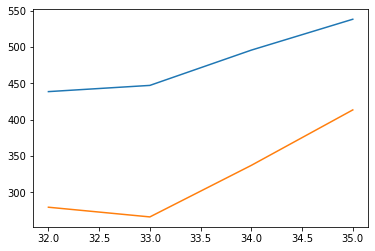

LW


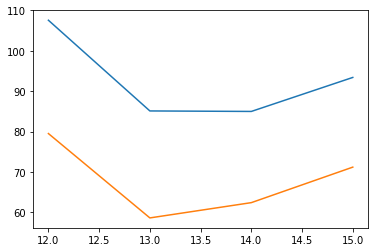

LVS


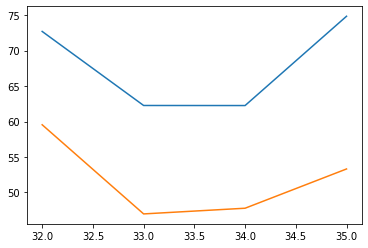

LDOS


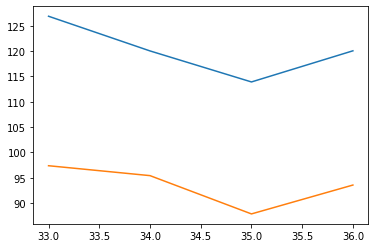

LEN


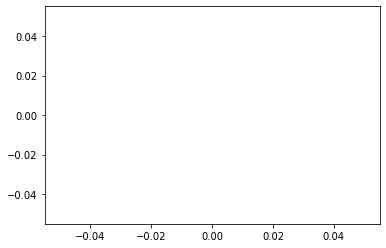

LNC


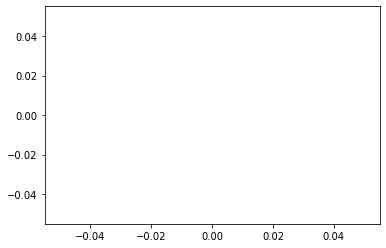

LIN


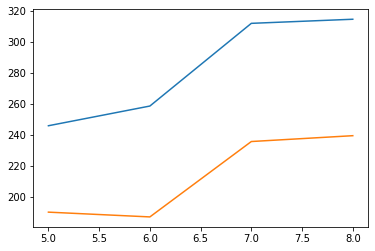

LYV


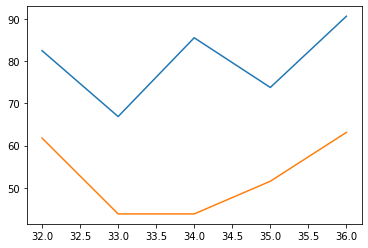

LKQ


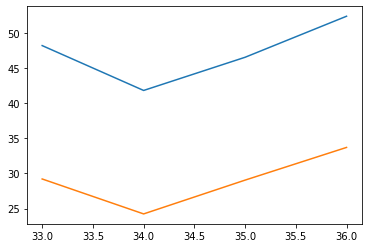

LMT


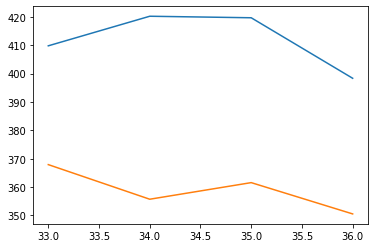

L


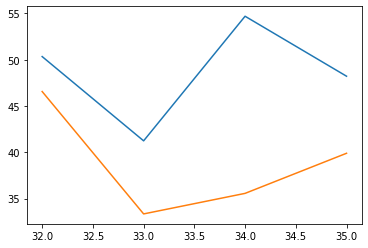

LOW


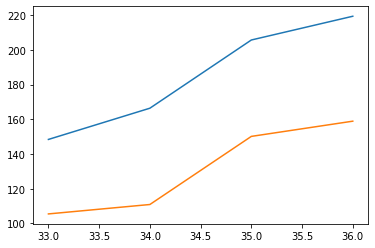

LUMN


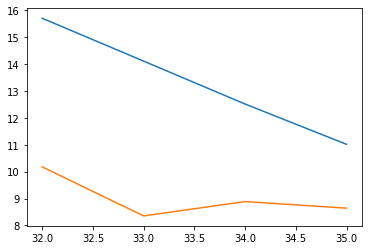

LYB


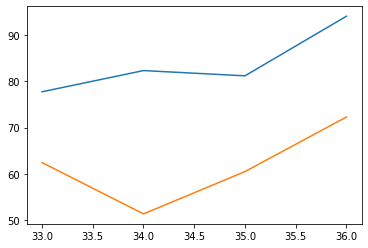

MTB


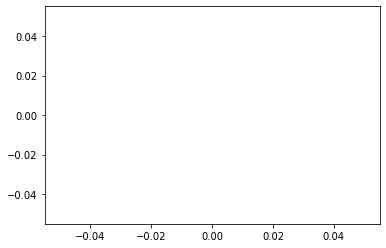

MRO


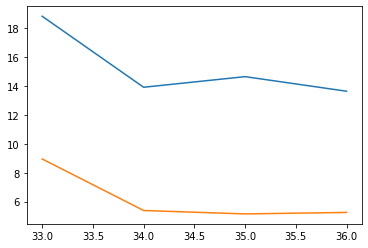

MPC


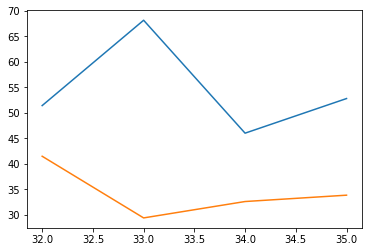

MKTX


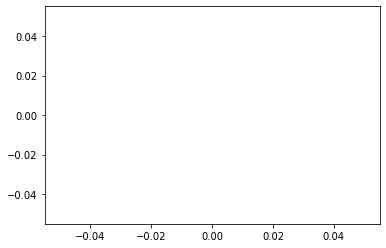

MAR


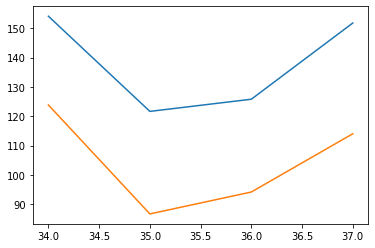

MMC


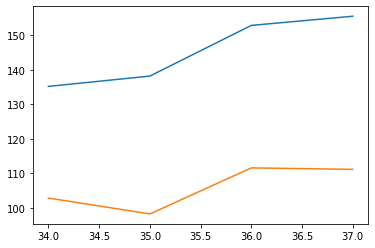

MLM


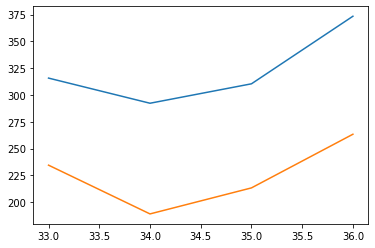

MAS


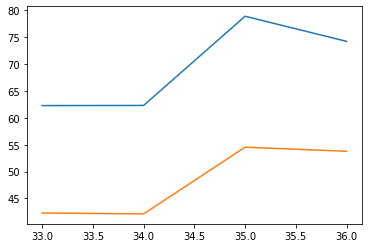

MA


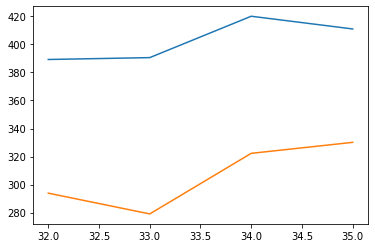

MTCH


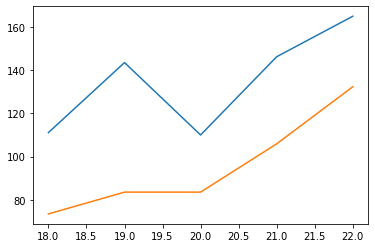

MKC


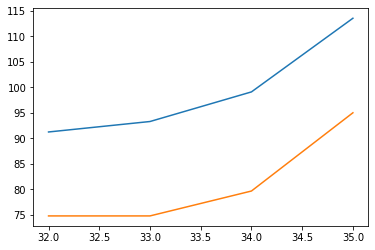

MCD


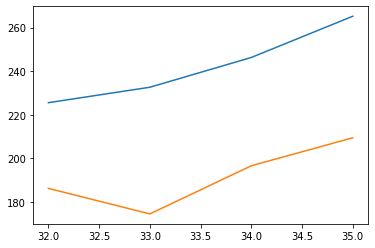

MCK


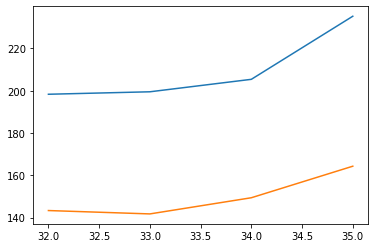

MDT


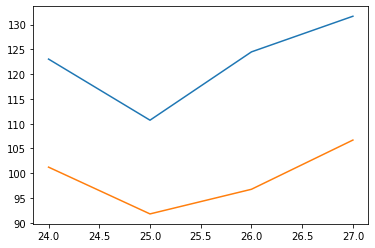

MRK


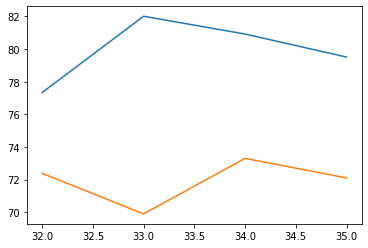

META


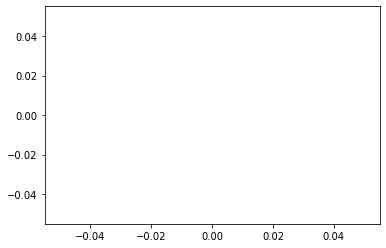

MET


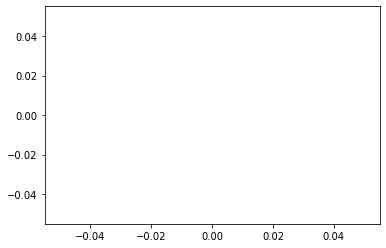

MTD


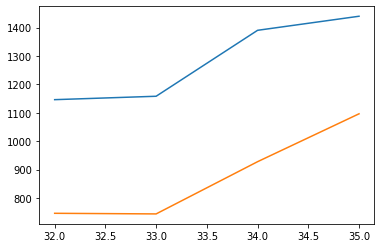

MGM


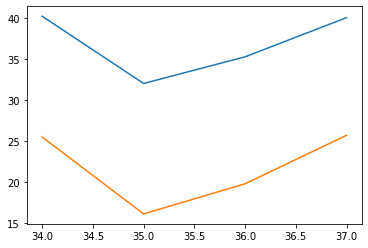

MCHP


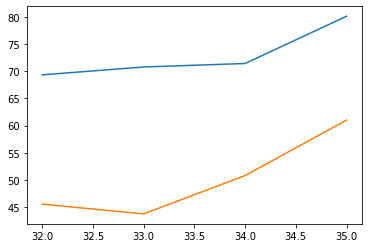

MU


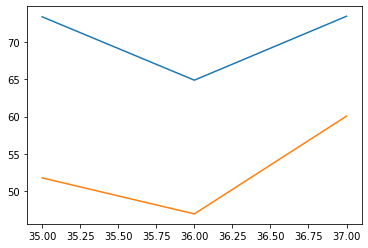

MSFT


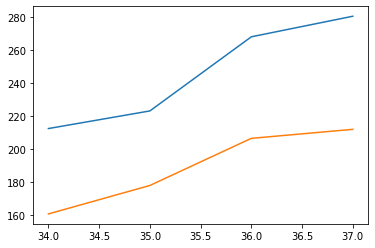

MAA


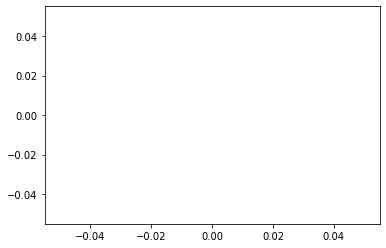

MRNA


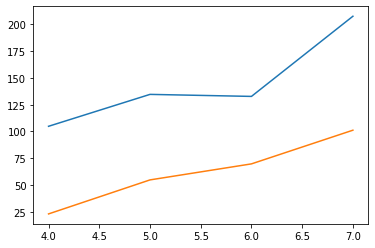

MHK


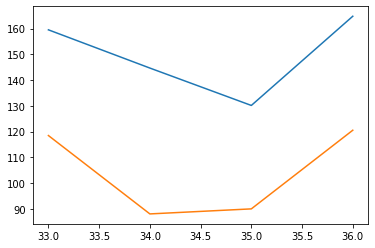

MOH


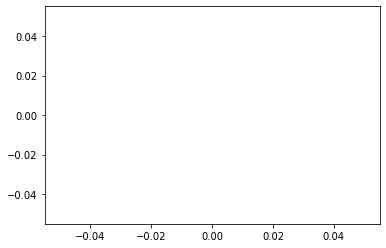

TAP


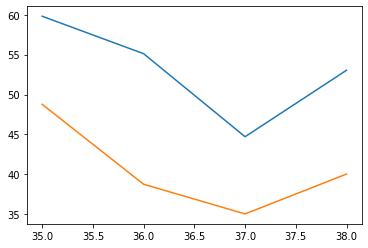

MDLZ


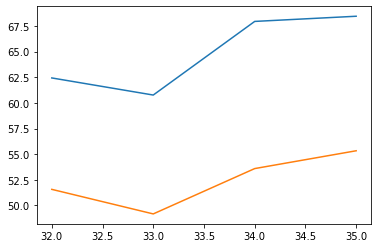

MPWR


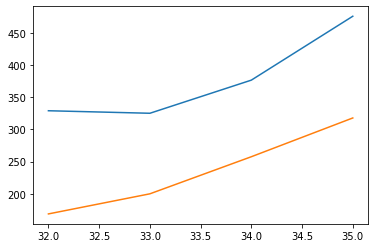

MNST


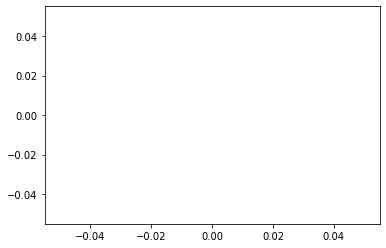

MCO


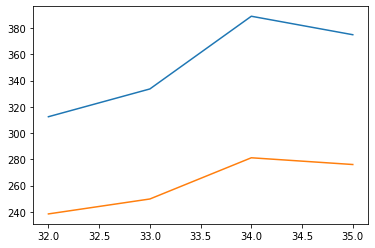

MS


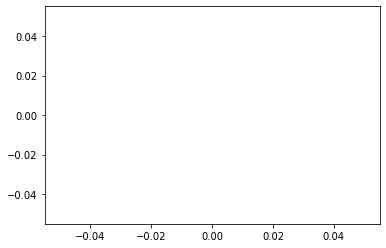

MOS


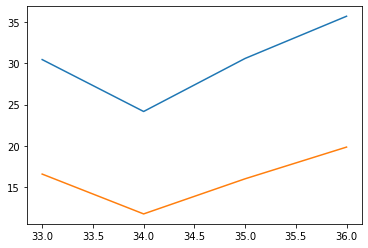

MSI


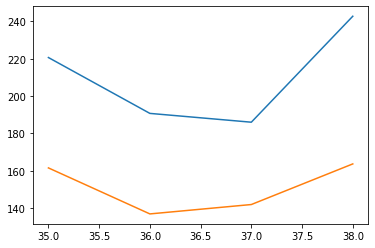

MSCI


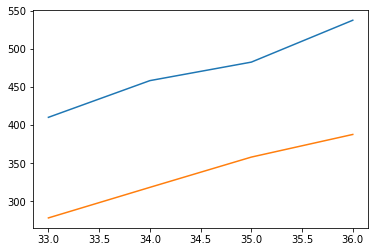

NDAQ


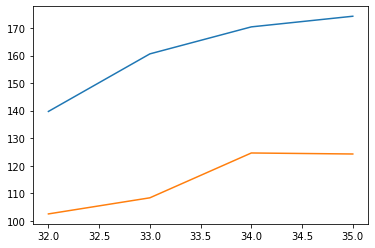

NTAP


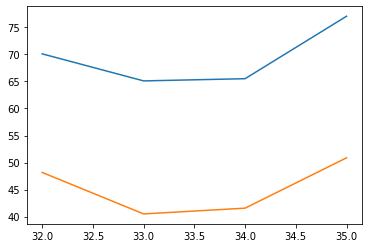

NFLX


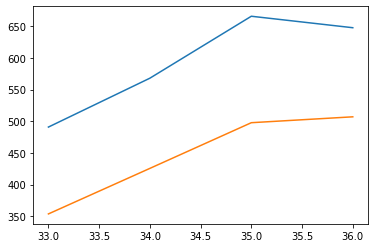

NWL


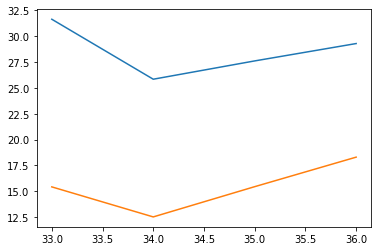

NEM


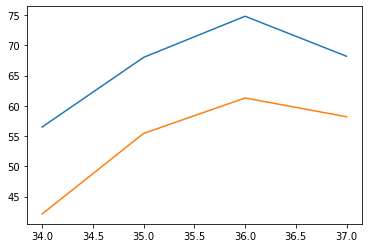

NWSA


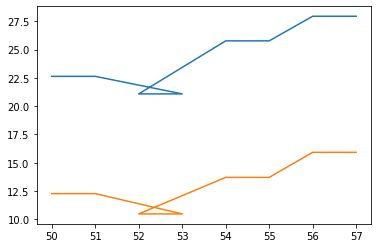

NWS


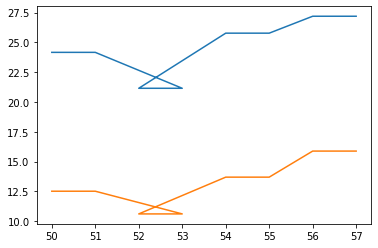

NEE


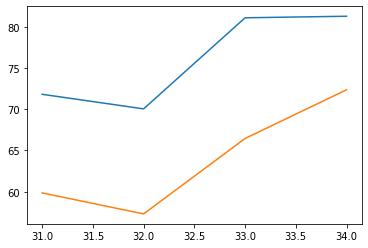

NLSN


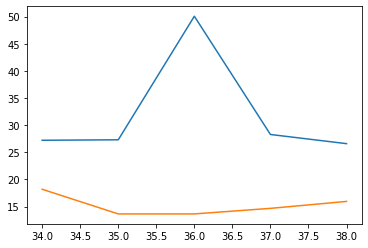

NKE


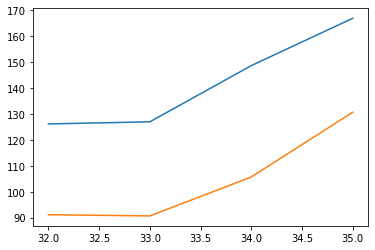

NI


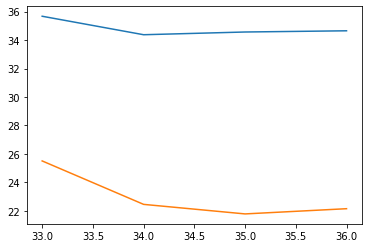

NDSN


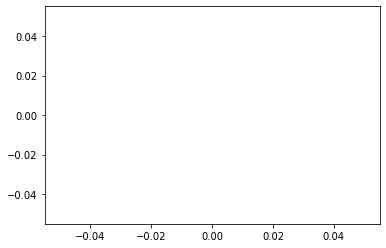

NSC


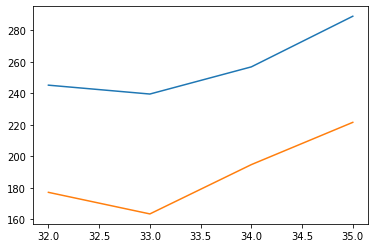

NTRS


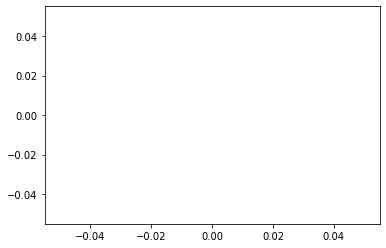

NOC


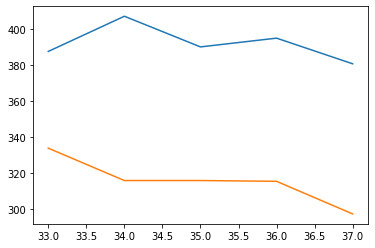

NLOK


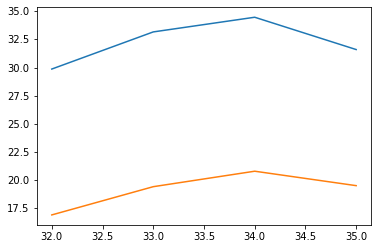

NCLH


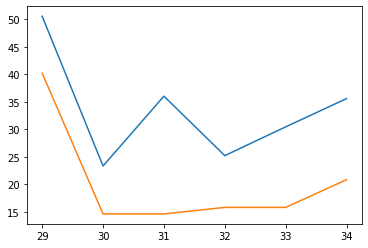

NRG


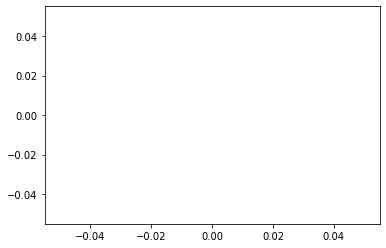

NUE


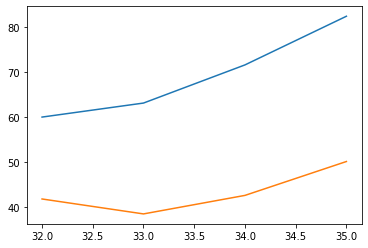

NVDA


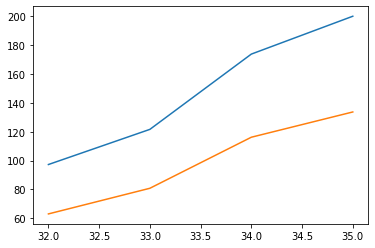

NVR


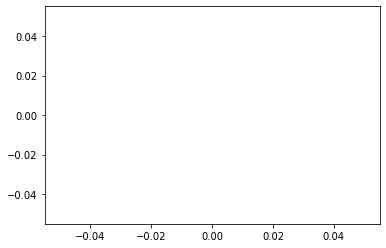

NXPI


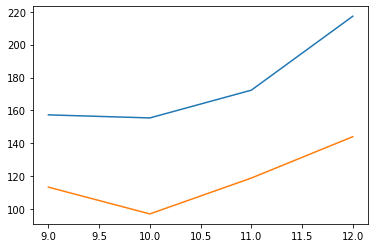

ORLY


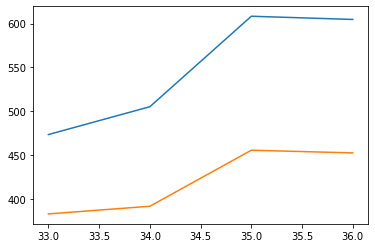

OXY


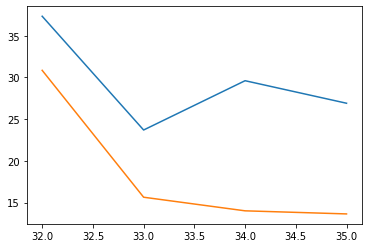

ODFL


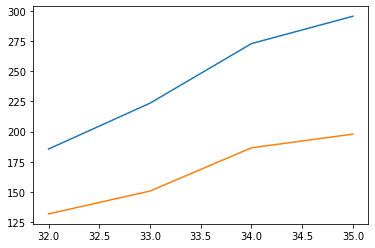

OMC


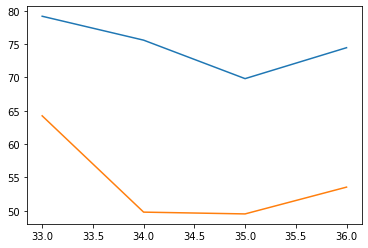

OKE


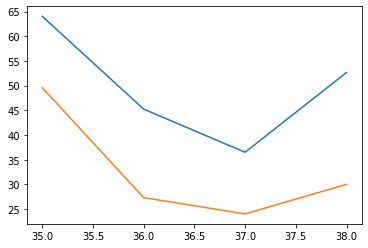

ORCL


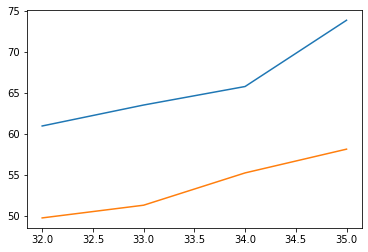

OGN


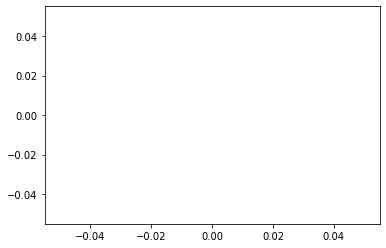

OTIS


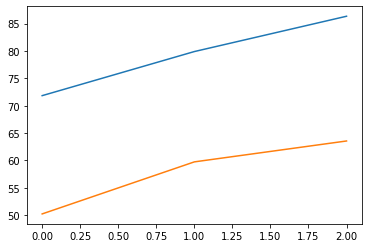

PCAR


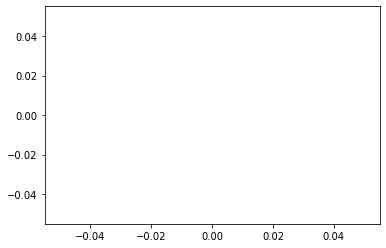

PKG


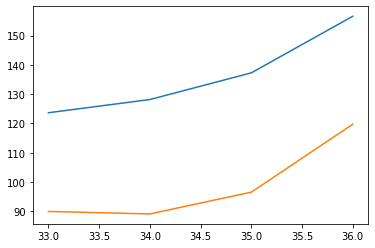

PARA


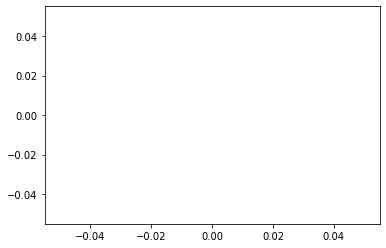

PH


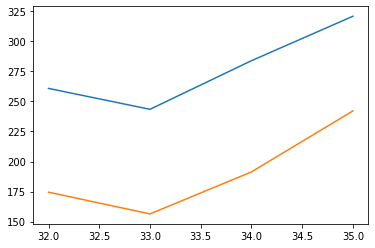

PAYX


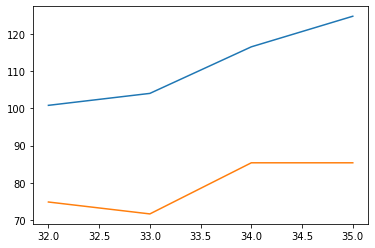

PAYC


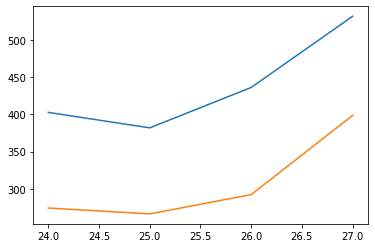

PYPL


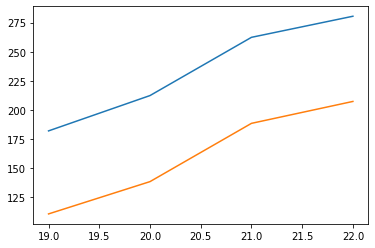

PENN


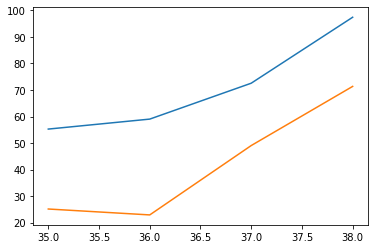

PNR


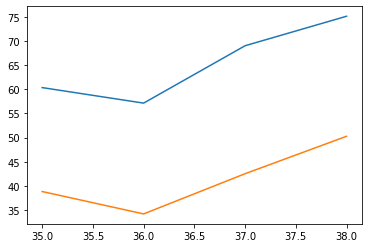

PEP


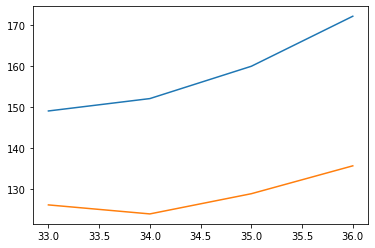

PKI


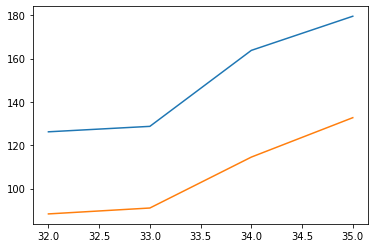

PFE


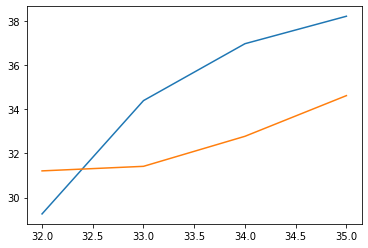

PM


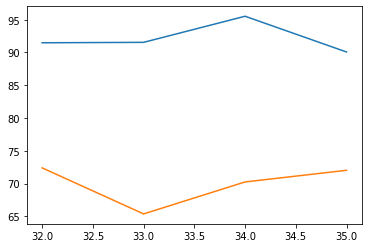

PSX


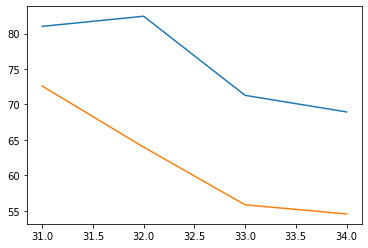

PNW


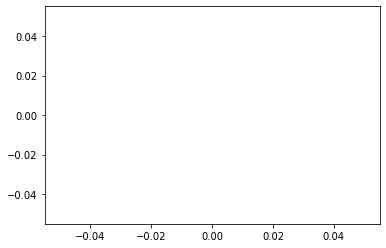

PXD


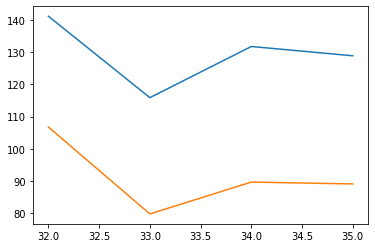

PNC


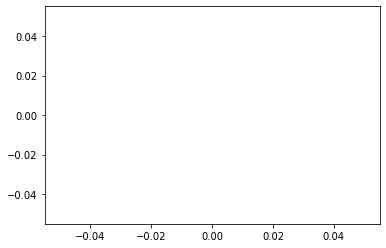

POOL


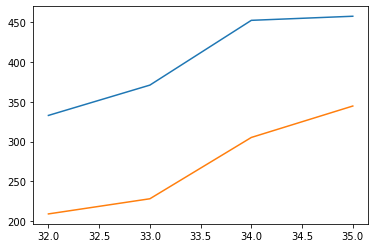

PPG


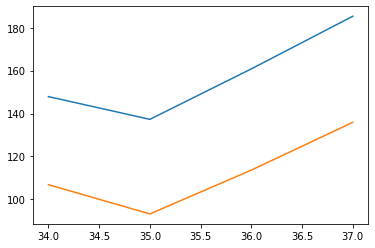

PPL


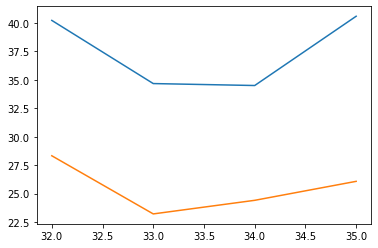

PFG


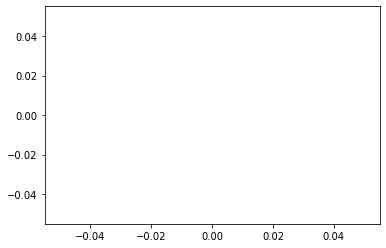

PG


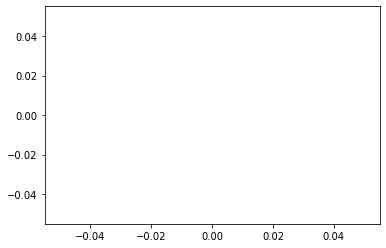

PGR


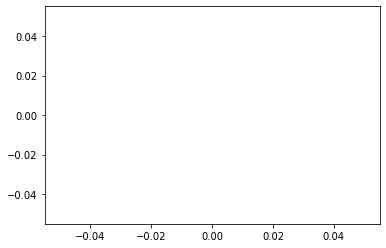

PLD


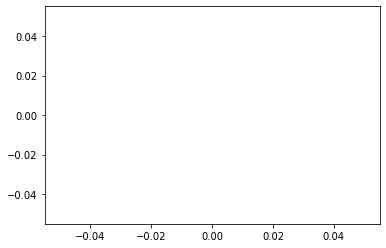

PRU


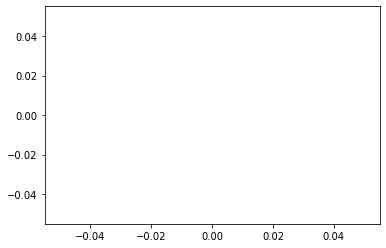

PEG


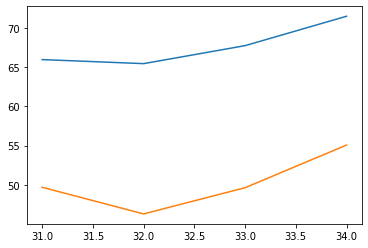

PTC


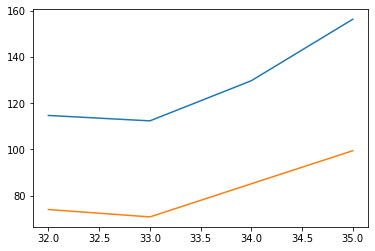

PSA


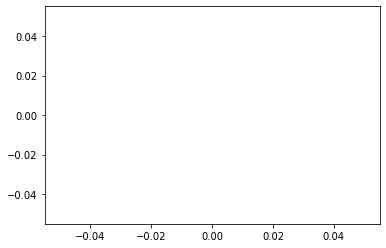

PHM


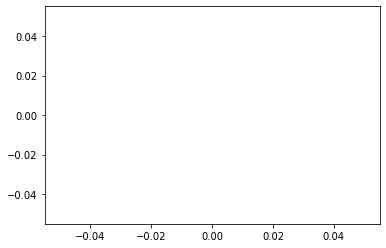

PVH


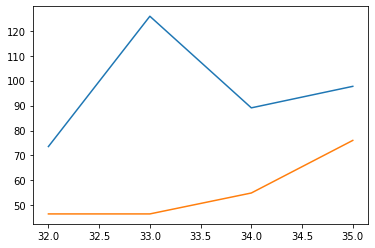

QRVO


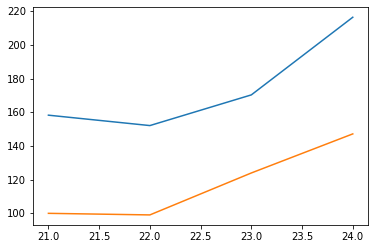

PWR


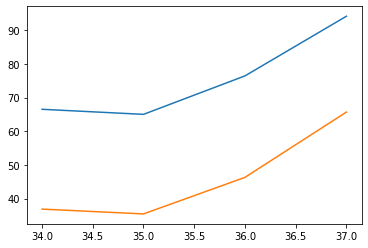

QCOM


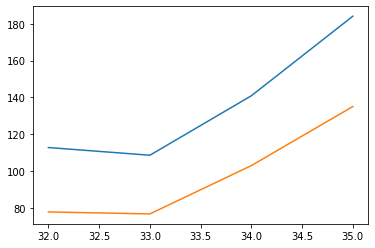

DGX


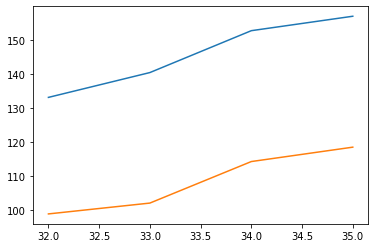

RL


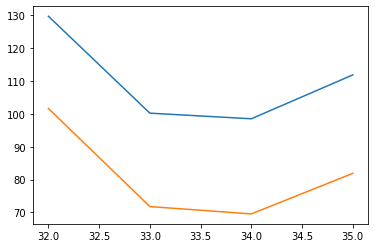

RJF


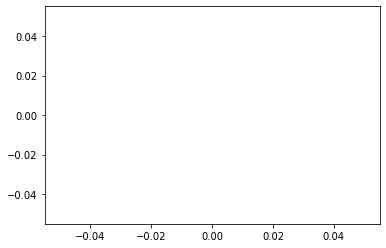

RTX


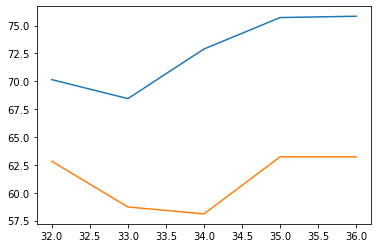

O


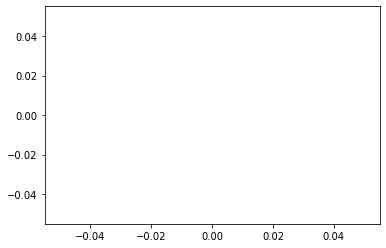

REG


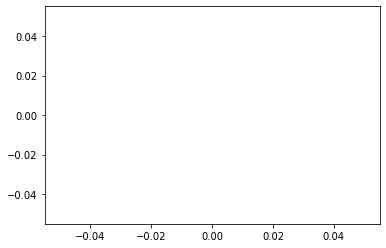

REGN


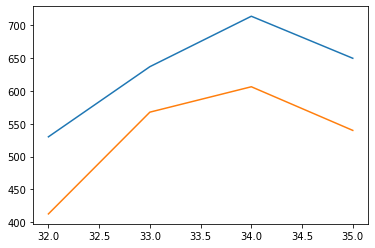

RF


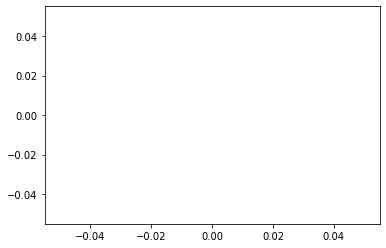

RSG


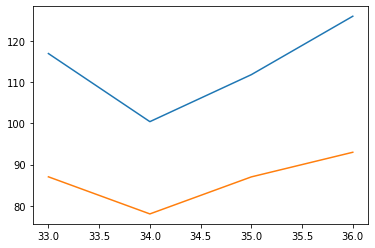

RMD


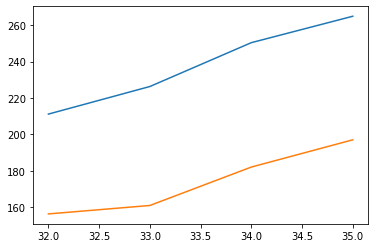

RHI


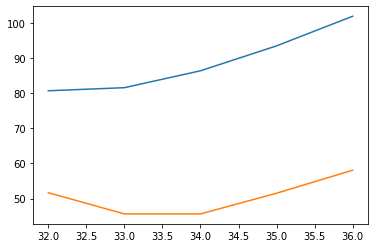

ROK


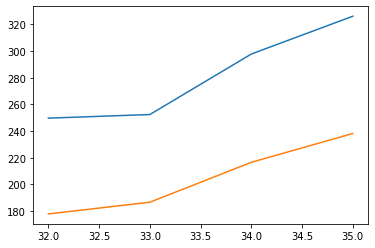

ROL


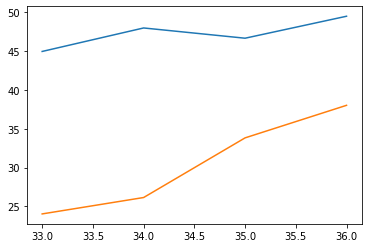

ROP


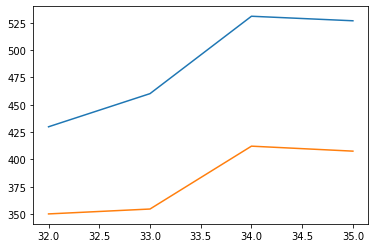

ROST


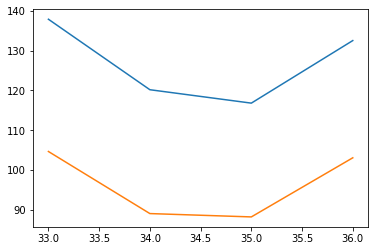

RCL


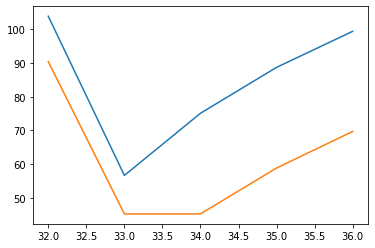

SPGI


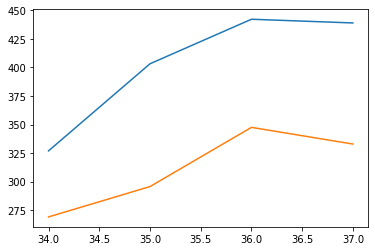

CRM


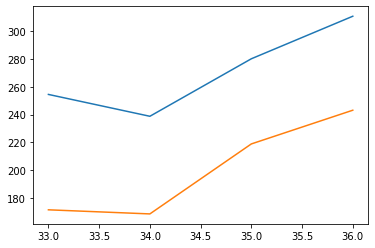

SBAC


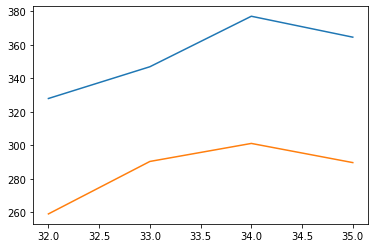

SLB


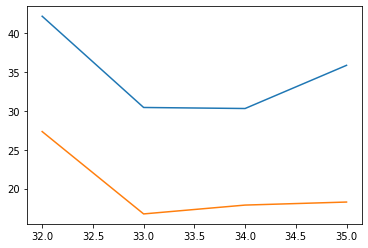

STX


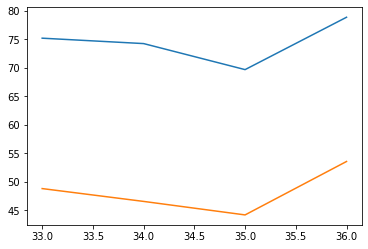

SEE


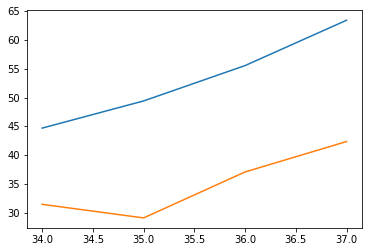

SRE


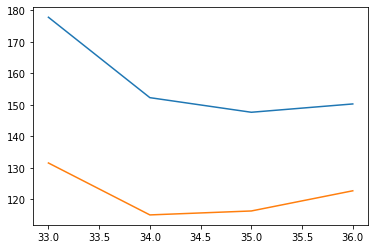

NOW


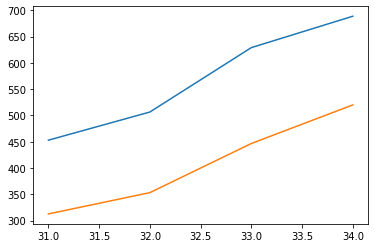

SHW


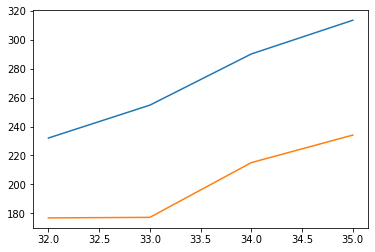

SBNY


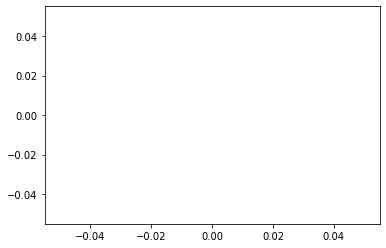

SPG


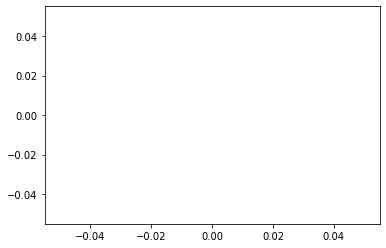

SWKS


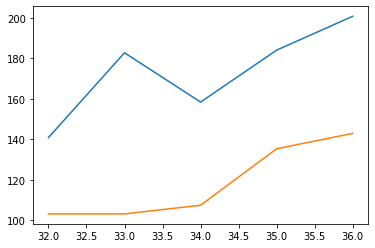

SJM


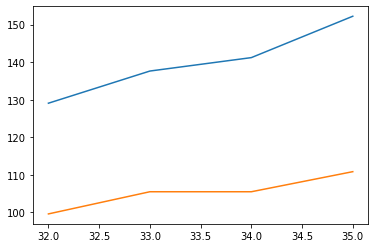

SNA


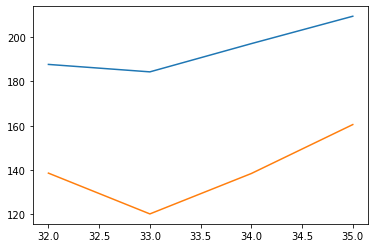

SEDG


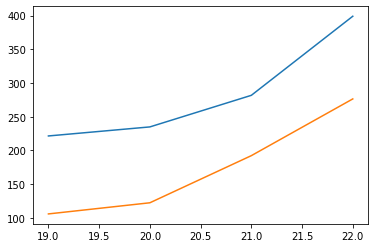

SO


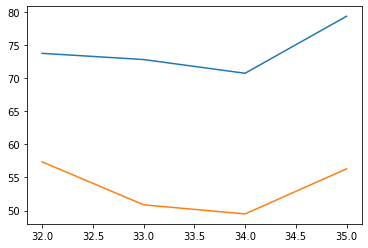

LUV


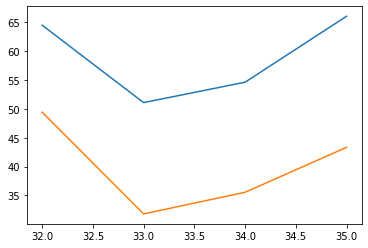

SWK


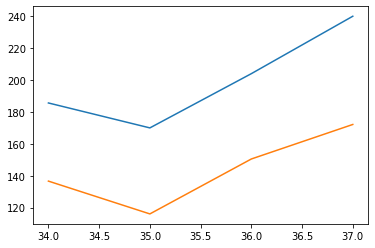

SBUX


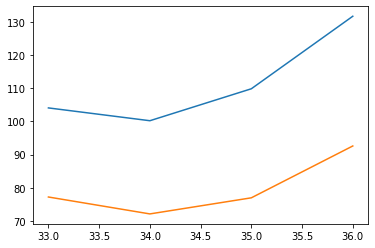

STT


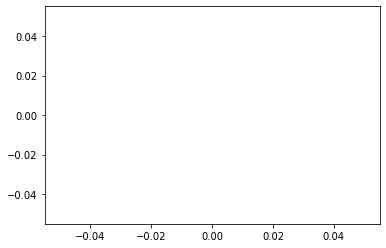

STE


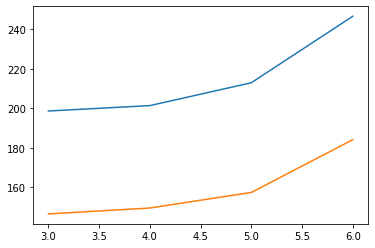

SYK


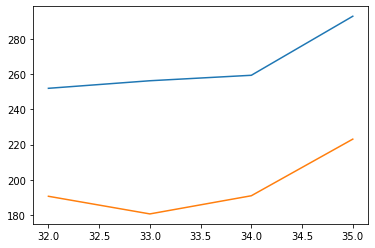

SIVB


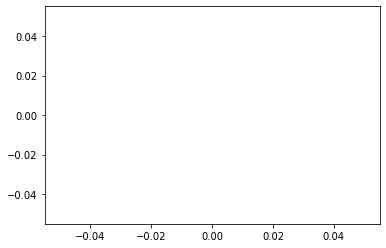

SYF


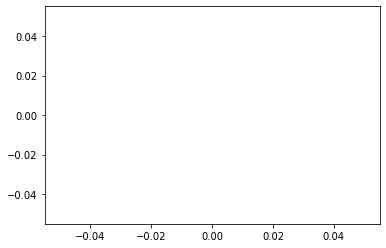

SNPS


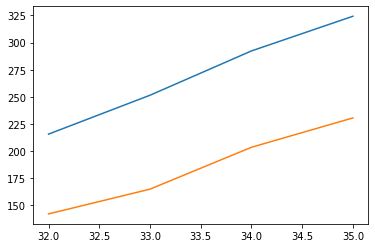

SYY


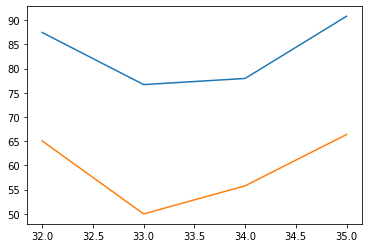

TMUS


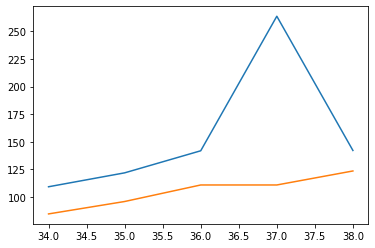

TROW


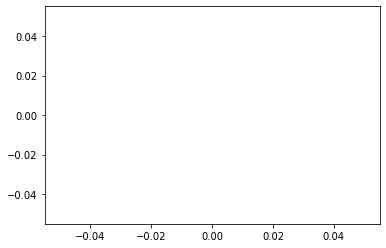

TTWO


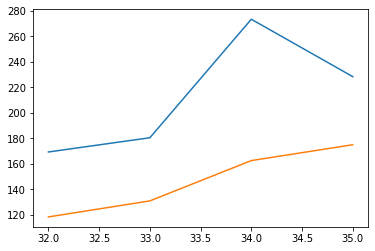

TPR


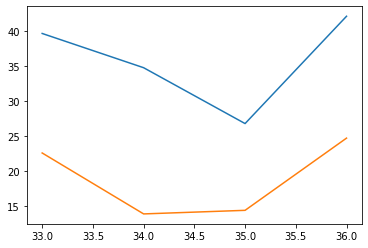

TGT


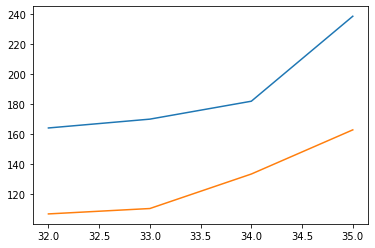

TEL


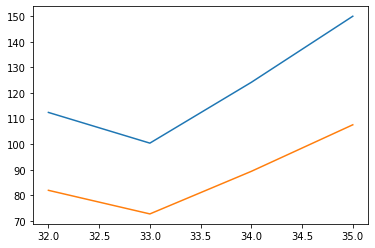

TDY


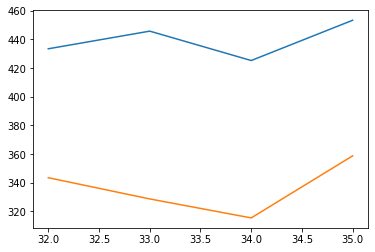

TFX


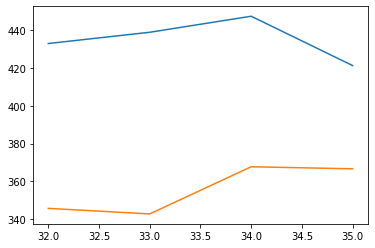

TER


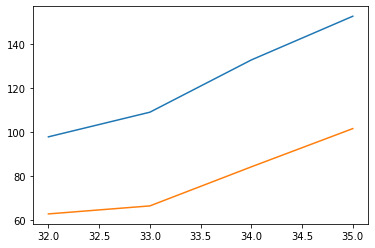

TSLA


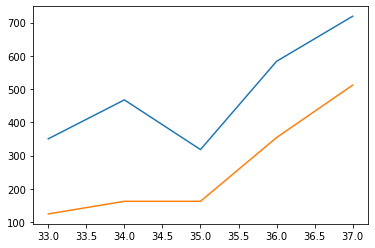

TXN


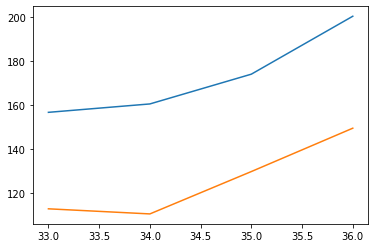

TXT


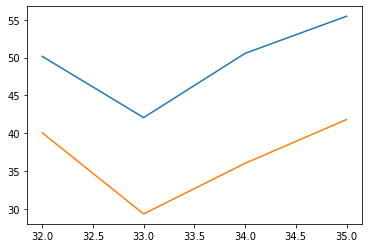

TMO


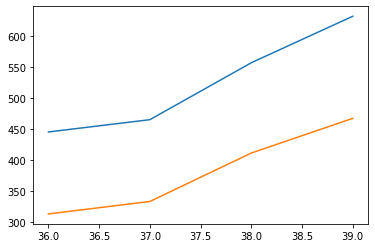

TJX


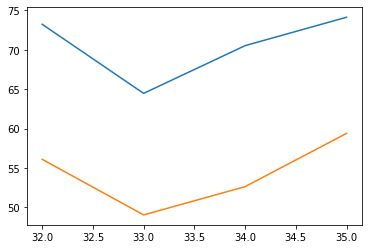

TSCO


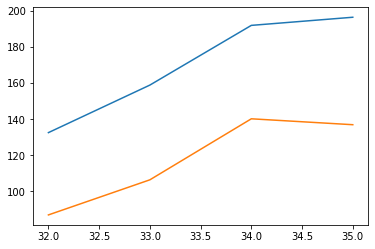

TT


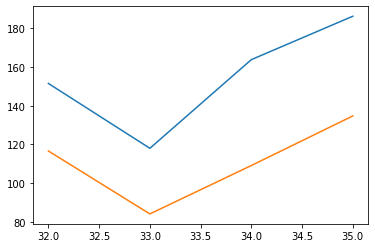

TDG


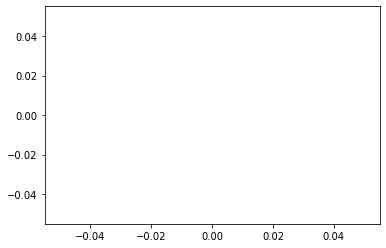

TRV


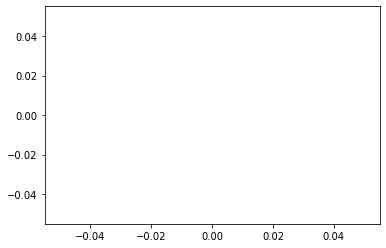

TRMB


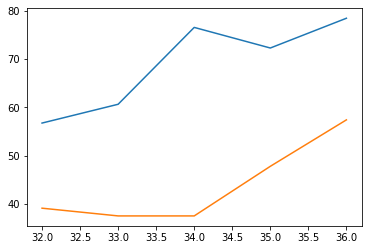

TFC


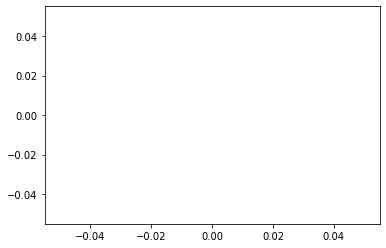

TWTR


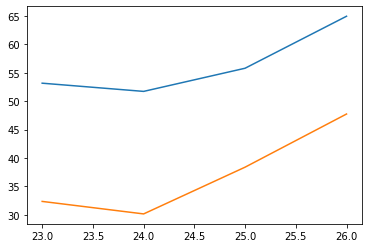

TYL


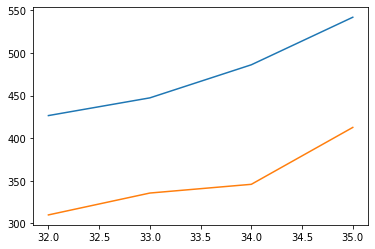

TSN


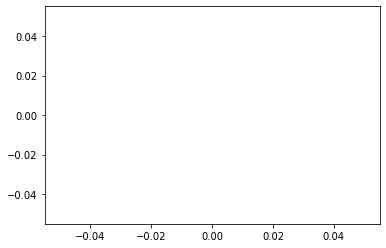

USB


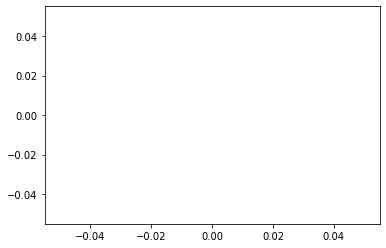

UDR


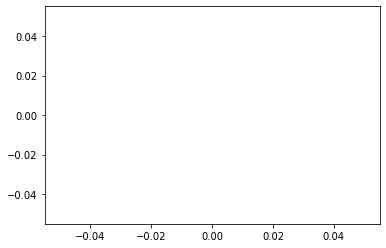

ULTA


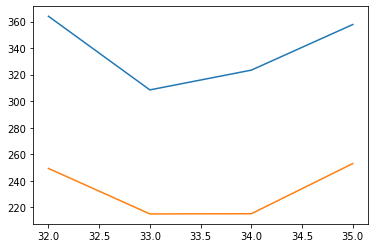

UAA


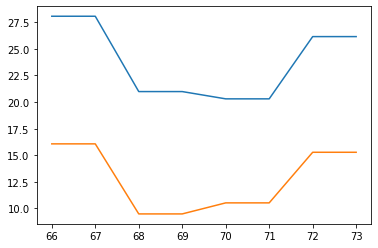

UA


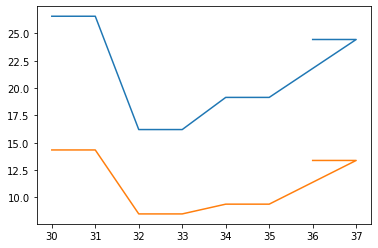

UNP


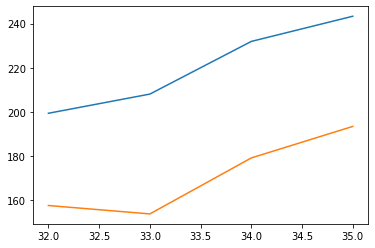

UAL


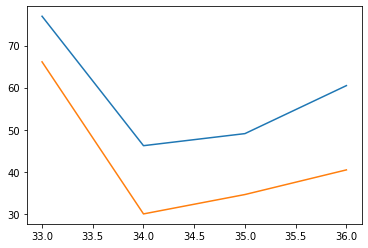

UPS


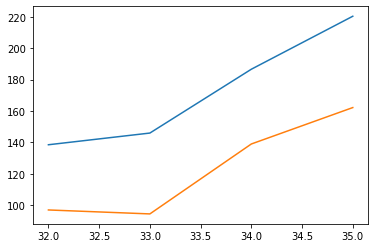

URI


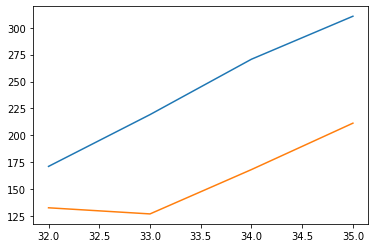

UNH


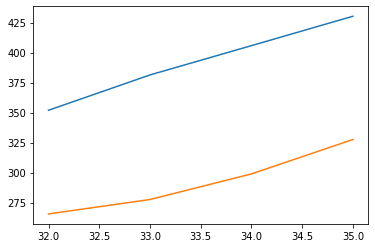

UHS


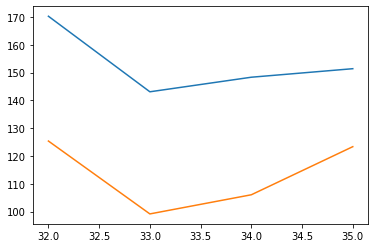

VLO


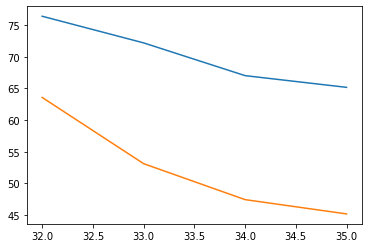

VTR


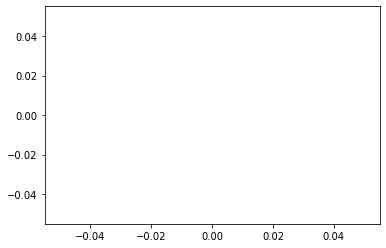

VRSN


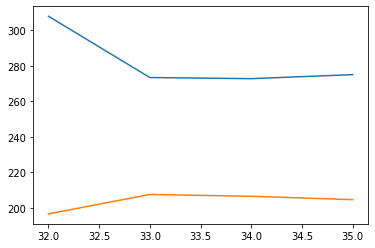

VRSK


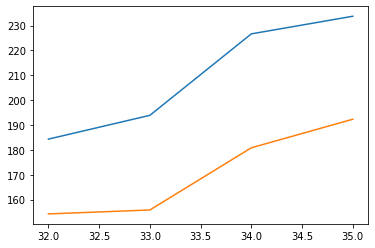

VZ


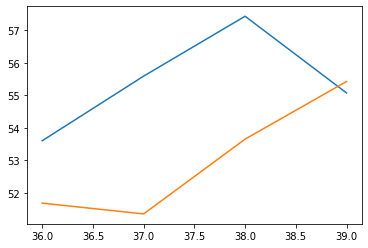

VRTX


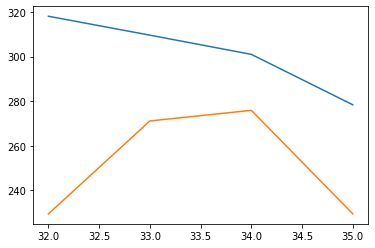

VFC


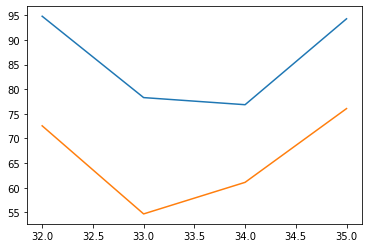

VTRS


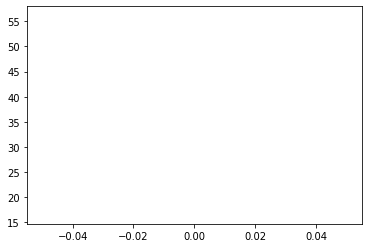

VICI


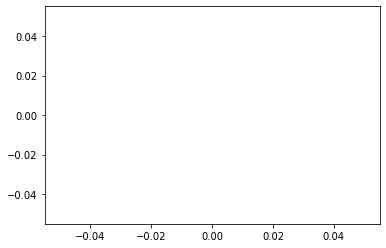

V


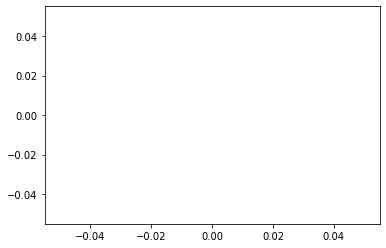

VNO


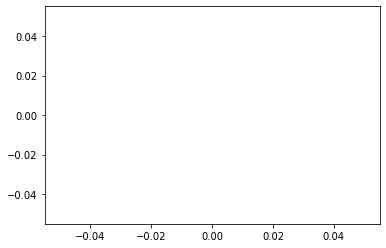

VMC


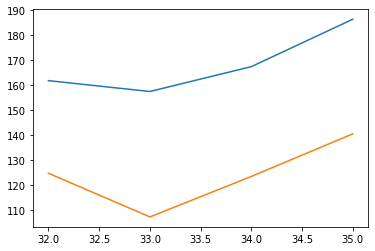

WAB


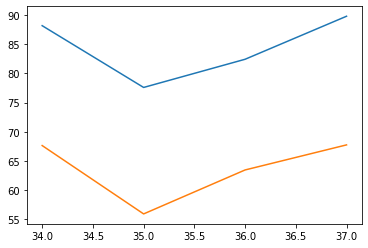

WBA


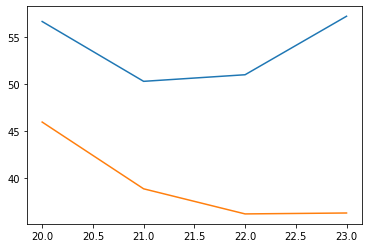

WMT


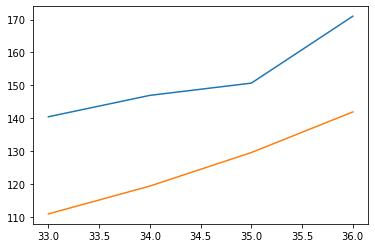

WBD


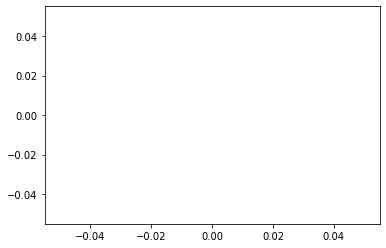

WM


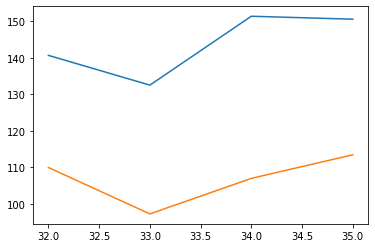

WAT


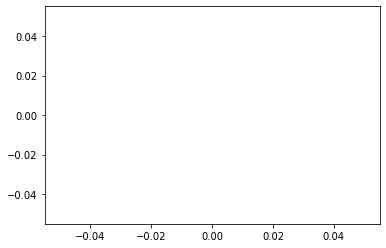

WEC


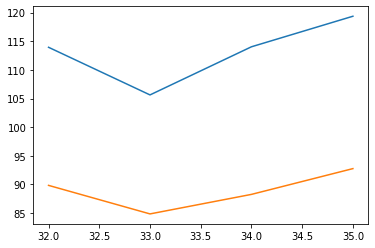

WFC


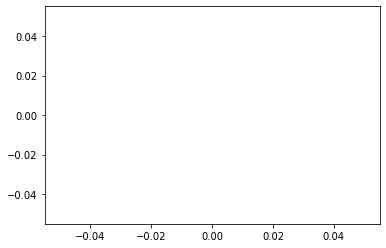

WELL


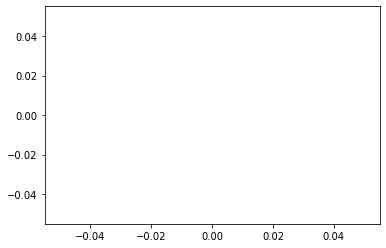

WST


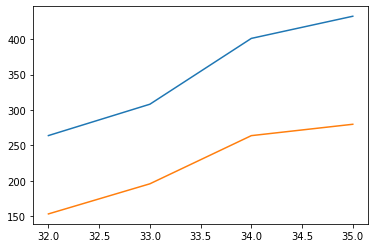

WDC


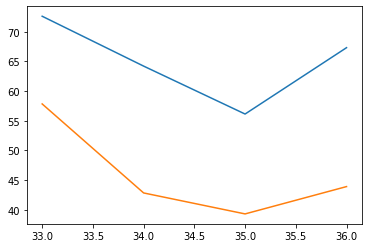

WRK


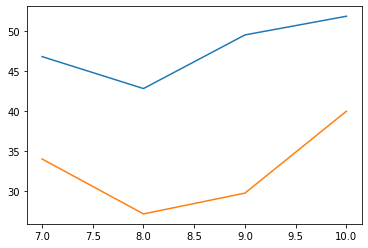

WY


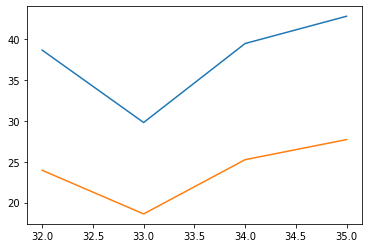

WHR


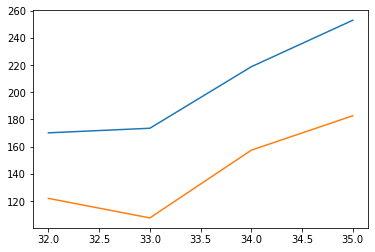

WMB


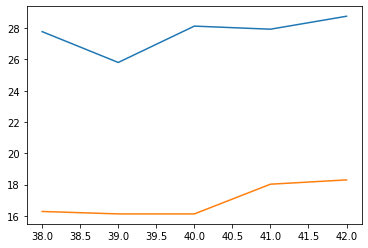

WTW


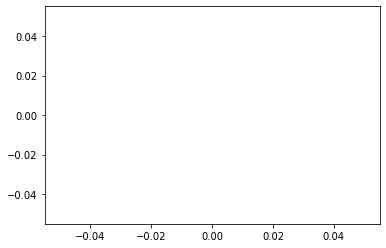

GWW


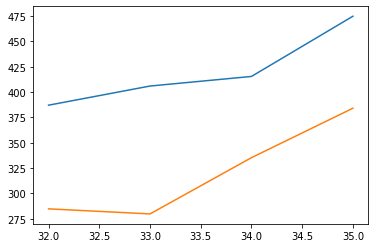

WYNN


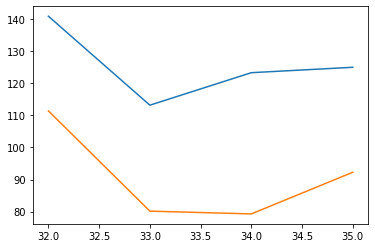

XEL


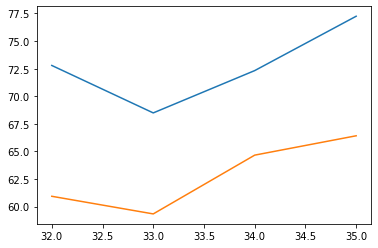

XYL


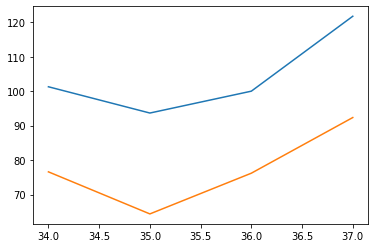

YUM


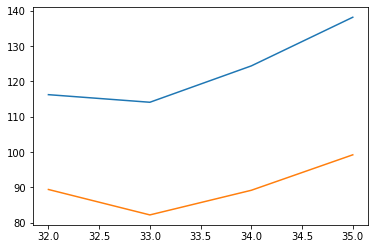

ZBRA


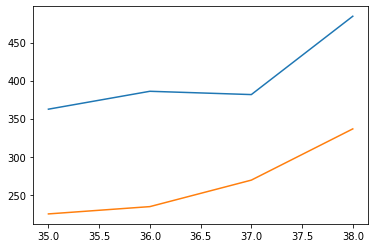

ZBH


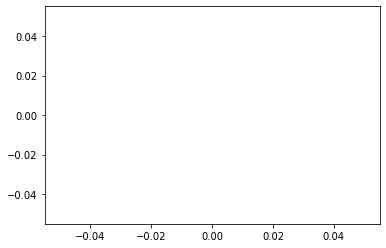

ZION


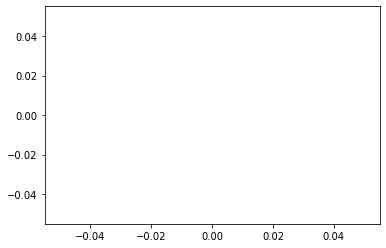

ZTS


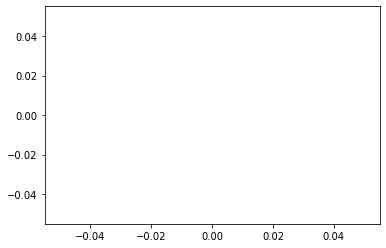

In [26]:
for ticker in sp500["Symbol"]:
    print(ticker)
    try:
        ticker_set = prediction_set[prediction_set["ticker"]==ticker]
        plt.plot(ticker_set["prediction"])
        plt.plot(ticker_set["adjclose"])
        plt.show()
    except:
        continue